### Load Python libraries

In [1]:
import pandas as pd

import numpy as np
from numpy import interp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from scipy.interpolate import interp1d
from scipy.interpolate import splrep, splev
from scipy.stats import linregress

import fiona

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import textwrap as tw

import rasterio as rs
from rasterio.plot import show
import rasterio.mask

import xarray

encoding = "utf_8"

In [2]:
# Modify display width
# (This is a personal preference)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Definitions

In [3]:
gases = ['CO2','CH4','N2O']
emission_units = {'CO2' : 'Gt','CH4' : 'Mt', 'N2O' : 'Mt'}
gas_units = {'CO2' : 'ppm','CH4' : 'ppb', 'N2O' : 'ppb'}

### Utility Functions

In [4]:
# convert a string to an int if it can be
# otherwise keep it a string

def stoi(s):
    try: 
        si = int(s)
        return si
    except ValueError:
        return s

In [5]:
def colfix (df,n):
    df.columns = [c[0] for c in df.columns[0:n]] + [c[1] for c in df.columns[n:]]

In [6]:
# A dataframe that stores key values as they are generated

constants = pd.DataFrame(columns=['Variable','Value','Units'])
constants = constants.set_index('Variable')

# Updating Estimates of Emissions from Animal Agriculture

We obtained country, species, herd and product type specific CO2, CH4 and N2O emission data for terrestrial livestock from the public version of GLEAM 2.0 (MacLeod et al. 2018) downloaded from http://www.fao.org/gleam/results/en/. GLEAM contains data for cattle, buffalo, sheep, goats, pigs and chickens, and attributes emissions to meat, milk and eggs. Although GLEAM further breaks down emissions based on herd type and production system, we used aggregate data for all herds and production types in the country. We did not include CO2 emissions linked to land-use change, as this is associated with increases in livestock production which are explicitly not considered by our model. 

We obtained livestock production data for 2019 (the most recent year available) from the “Production_LivestockPrimary” datafile in FAOSTAT (FAO 2021). We extracted from Production_LivestockPrimary the amount (in tonnes), for all countries, of primary domestic production of meat from cattle, buffalo, sheep, goat, pig, chicken and duck, milk from cows, buffalo, sheep and goat, and eggs from poultry.  We computed meat and protein yields from the carcass weight data reported by GLEAM.
We scaled the GLEAM emission data reported for entire herds based on carcass weight for meat, and production weight for milk and eggs. As GLEAM does not provide data for ducks, we used values for chicken. The scaling was done using country-specific livestock production data and regional data from GLEAM. 


## FAOSTAT Country Data

We need to use a consistent set of countries and country names. We use the FAOSTAT country list as our reference, and have accumulated a set of alternative names, punctuations and spellings from other datasets that we load here and use throughout.

In [7]:
country_group = pd.read_csv("FAOSTAT/FAOSTAT_Country_Group.csv",encoding = encoding)
fao_countries = list((pd.read_csv("Inputs/fao_countries.csv", encoding = encoding))['Area'].unique())

country_aliases = pd.read_csv("Inputs/country_aliases.csv",encoding = encoding)
country_alias_map = {}

for i,r in country_aliases.iterrows():
    country_alias_map[r['Alias']] = r['FAO Country']

for faoc in fao_countries:
    country_alias_map[faoc] = faoc

## Species and Production Emissions Data From Global GLEAM 2.0 

We use data from the United Nations Food and Agriculture Organization (FAO) Global Livestock Environmental Assessment Model [GLEAM](http://www.fao.org/gleam/resources/en/), version 2.0, to estimate gloabl emissions from animal agriculture. 

GLEAM is a modelling framework that simulates the interaction of activities and processes involved in livestock production and the environment. It was designed to allow policymakers to study the environmental consequences of changes in different steps of livestock supply chains. But we make use only of its baseline model of emissions broken down by species, product and region. 

We use the public data [available here]( http://www.fao.org/fileadmin/user_upload/gleam/docs/GLEAM_Data_public_release.xlsx).



In [8]:
# This is a lookup table to connect category, product and production process from GLEAM to species/product pairs

commodity_info = pd.DataFrame( data = 
    [
        ['Meat','buffalo_meat','Buffalo','All systems','Whole herd'],
        ['Meat','cattle_meat','Cattle','All systems','Whole herd'],
        ['Meat','chicken_meat','Chickens','All systems','Whole herd'],
        ['Meat','duck_meat','Chickens','All systems','Whole herd'], # no GLEAM data so use Chickens
        ['Meat','goat_meat','Goats', 'All systems','Whole herd'],
        ['Meat','sheep_meat','Sheep', 'All systems','Whole herd'],
        ['Meat','pig_meat','Pigs', 'All systems','Whole herd'],
        ['Milk','buffalo_milk','Buffalo','All systems','Dairy'],
        ['Milk','cow_milk','Cattle','All systems','Whole herd'],
        ['Milk','goat_milk','Goats','All systems','Whole herd'],
        ['Milk','sheep_milk','Sheep','All systems','Whole herd'],
        ['Eggs','eggs','Chickens','All systems','Whole herd']
    ],
    columns = ['Product Type','Category','Species','System','Type']
            
)

In [9]:
# GLEAM organizes things by Meat, Milk and Eggs and uses different descriptions for the products of each

prods = ['Meat','Milk','Eggs']

gleam_var = {
    'Meat' : 'PROD: Meat - carcass weight', 
    'Milk' : 'PROD: Milk - fresh weight', 
    'Eggs' : 'PROD: Eggs - shell weight'
}

In [10]:
# GLEAM expresses gas-specific emission intensities in terms of emissions per unit protein
# These factors, which are derived from data in GLEAM, allow for conversion of protein units to FAO production units 
#
# carcass weight for meat
# liquid weight for milk
# shell weight for eggs

# use data from old version of GLEAM to get conversion from protein to production units

gleamall = pd.read_csv("GLEAM/GLEAM.csv", encoding=encoding)
df = pd.pivot_table(gleamall,index=['Species','System','Country','Type'],columns=['Variable'],aggfunc={'Value' : sum}).reset_index()
df.columns = df.columns = [c[0] for c in df.columns[0:4]] + [c[1] for c in df.columns[4:]]
df = df.groupby(['Species']).sum().reset_index()
df['CONV: Eggs'] = df['PROD: Eggs - shell weight']/df['PROD: Eggs - protein amount']
df['CONV: Milk'] = df['PROD: Milk - fresh weight']/df['PROD: Milk - protein amount']
df['CONV: Meat'] = df['PROD: Meat - carcass weight']/df['PROD: Meat - protein amount']
df[['Species'] + [c for c in df.columns if c.startswith('CONV')]]

data = []
for i,r in df.iterrows():
    for c in ['Eggs','Milk','Meat']:
        if r['CONV: %s' %c] > 0:
            data.append([r.Species,c,r['CONV: %s' %c]])
            
conversions = pd.DataFrame(data=data,columns=['Species','Commodity','Conversion'])
conversions = conversions.set_index(['Species','Commodity'])
conversions.loc[('Buffalo','Milk'),'Conversion'] = conversions.loc[('Cattle','Milk')]['Conversion']
conversions = conversions.reset_index()

In [11]:
conversions

,Species,Commodity,Conversion
0,Buffalo,Milk,29.656719
1,Buffalo,Meat,6.928637
2,Cattle,Milk,29.656719
3,Cattle,Meat,6.506834
4,Chickens,Eggs,8.064516
5,Chickens,Meat,7.017544
6,Goats,Milk,26.690530
7,Goats,Meat,7.440476
8,Pigs,Meat,7.616146
9,Sheep,Milk,16.485994


## GLEAM Emissions Intensity data

In [12]:
gleam2 =  pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "GLEAM_GRL", skiprows=2)

# harmonize  names

gleam2.loc[gleam2[gleam2.Species == "Buffaloes"].index,'Species'] = "Buffalo"
gleam2.loc[gleam2[gleam2.Species == "Chicken"].index,'Species'] = "Chickens"

# select products

gleam2 = gleam2[gleam2.Commodity.isin(prods)]
gleam2 = gleam2.merge(conversions,on=["Species","Commodity"],how="left")

# we don't count emissions due to land use change since those assume increasing production 

gleam2['Total CO2'] -= gleam2['LUC SoyPalm CO2']
gleam2['Total CO2'] -= gleam2['LUC pasture CO2']

for gas in gases:
    gleam2['EI_%s_perkg' % (gas)] = gleam2['Total %s' % gas] / (gleam2['Production'] * gleam2['Conversion'])
gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")]
df = gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")].copy()

# adjust CO2eq --> Gt (CO2) or Mt (CH4 and N2O)
for c in df:
    if 'CO2' in c and 'EI' not in c:
        df[c] = df[c] / 1E+12
        
    if 'CH4' in c and 'EI' not in c:
        df[c] = df[c] / (34 * 1E+9)
        
    if 'N2O' in c and 'EI' not in c:
        df[c] = df[c] / (298 * 1E+9)

## GLEAM Country -> Regions Mapping

This version of GLEAM only reports regionalized data. Would love to use country-specific data but they do not make it available and declined our request to share it.

In [13]:
gleam2_c = pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "COUNTRY_LIST", index_col=None, header=None, names=["Country"])

data = []
region = ""

for i,r in gleam2_c.iterrows():
    if r.Country[0:3] == "   ":
        data.append([region,r.Country[3:]])
    else:
        region = r.Country
        
gleam2_countries = pd.DataFrame(data=data,columns=['Region','Country'])

gleam2['Region'] = gleam2['Region'].str.upper()
gleam2c = gleam2_countries.merge(gleam2,on="Region",how='left')
gleam2c = gleam2c[gleam2c.System == "Aggregated"]

gleam2c['Country Mapped'] = gleam2c['Country'].map(country_alias_map)
gleam2c_countries = gleam2c['Country Mapped'].unique()

gleam2c = gleam2c[['Country Mapped','Species', 'System', 'Commodity', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']]
gleam2c.columns = ['Area','Species', 'System', 'Product', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']

## Load FAO Production and Trade Data

In [14]:
datafile = "Inputs/FAOSTAT_production_categories.csv"
fao_production_categories = pd.read_csv(datafile,encoding = encoding)
        
datafile = "FAOSTAT/Filtered/Production_LivestockPrimary_E_All_Data_(Normalized).csv"

fao_livestock_primary = pd.read_csv(datafile,encoding = "latin_1")
    
year = np.max(fao_livestock_primary.Year.values)
fao_livestock_primary = fao_livestock_primary[
        (fao_livestock_primary.Area.isin(fao_countries)) 
        & (fao_livestock_primary.Year == year) 
        & (fao_livestock_primary.Element == 'Production' ) 
        & (fao_livestock_primary.Unit == "tonnes")]
fao_livestock_primary.Value = fao_livestock_primary.Value.astype('Int64')
fao_livestock_primary = fao_livestock_primary.merge(fao_production_categories, on = "Item")
fao_livestock_primary['Domestic Production'] = fao_livestock_primary['Value'] * fao_livestock_primary['Category Weight']
fao_livestock_primary = fao_livestock_primary[['Area','Category','Domestic Production']].groupby(['Area','Category']).sum().reset_index()

In [15]:
datafile = "FAOSTAT/Filtered/Trade_Crops_Livestock_E_All_Data_(Normalized).csv"

fao_livestock_trade = pd.read_csv(datafile,encoding = "latin_1")
    
year = np.max(fao_livestock_trade.Year.values)
fao_livestock_trade = fao_livestock_trade[
        (fao_livestock_trade.Area.isin(fao_countries)) 
        & (fao_livestock_trade.Year == year) 
        & (fao_livestock_trade.Element.isin(['Export Quantity','Import Quantity'])) 
]
fao_livestock_trade.Value = fao_livestock_trade.Value.astype('Int64')
fao_livestock_trade = fao_livestock_trade.merge(fao_production_categories, on = "Item")
fao_livestock_trade['Primary Equivalent'] = fao_livestock_trade['Value'] * fao_livestock_trade['Category Weight']
fao_livestock_trade = fao_livestock_trade[['Area','Category','Element','Primary Equivalent']].groupby(['Area','Category','Element']).sum().reset_index()
fao_livestock_trade = fao_livestock_trade.pivot_table(index=['Area','Category'],columns=['Element'],aggfunc={'Primary Equivalent' : sum}).reset_index().fillna(0)
fao_livestock_trade.columns = [c[0] for c in fao_livestock_trade.columns[0:2]] + [c[1] for c in fao_livestock_trade.columns[2:]]

In [16]:
livestock_data = fao_livestock_primary.merge(fao_livestock_trade,on=['Area','Category'],how='left').fillna(0)
livestock_data['Consumption'] = livestock_data['Domestic Production'] + livestock_data['Import Quantity'] - livestock_data['Export Quantity']

In [17]:
incols = list(livestock_data.columns)

# create columns for Emissions data
for gas in gases:
    livestock_data['Emissions|%s' % gas] = 0

livestock_data = livestock_data.merge(commodity_info,on="Category",how="left")
livestock_data = livestock_data.merge(gleam2c, 
            left_on=['Area','Product Type','Species'], 
            right_on=['Area','Product','Species'],
            how="right")

# GLEAM uses AR5 numbers for GWP
gwp = {
    'CO2' : 1,
    'CH4' : 34,
    'N2O' : 298
}

# scale from Gt --> Mt for CH4 and N2O

scale = {
    'CO2' : 1,
    'CH4' : 1000,
    'N2O' : 1000
}


for gas in gases:
    livestock_data['Emissions|%s|Livestock|Domestic' % gas] =  ( livestock_data['Domestic Production'] 
    * livestock_data['EI_%s_perkg' % (gas)] 
    * scale[gas]
    / gwp[gas]
    / 1E+09 )

    
    
livestock_data = livestock_data[incols 
                                + ['Emissions|%s|Livestock|Domestic' % gas  for gas in gases]]

livestock_data = livestock_data.dropna()

In [18]:
datafile = "FAOSTAT/Filtered/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv"
fao_detailed_livestock_trade = pd.read_csv(datafile,encoding = "latin_1")
fao_detailed_livestock_trade = fao_detailed_livestock_trade[
        (fao_detailed_livestock_trade.Element.isin(['Import Quantity'])) 
]

fao_detailed_livestock_trade.Value = fao_detailed_livestock_trade.Value.astype('Int64')
fao_detailed_livestock_trade = fao_detailed_livestock_trade.merge(fao_production_categories, on = "Item",how='left')
fao_detailed_livestock_trade['Primary Equivalent'] = fao_detailed_livestock_trade['Value'] * fao_detailed_livestock_trade['Category Weight']
fao_detailed_livestock_trade = fao_detailed_livestock_trade[['Reporter Countries','Partner Countries','Category','Element','Primary Equivalent']].groupby(['Reporter Countries','Partner Countries','Category','Element']).sum().reset_index()
fao_detailed_livestock_trade = fao_detailed_livestock_trade.pivot_table(index=['Reporter Countries','Partner Countries','Category'],columns=['Element'],aggfunc={'Primary Equivalent' : sum}).reset_index().fillna(0)
fao_detailed_livestock_trade.columns = [c[0] for c in fao_detailed_livestock_trade.columns[0:3]] + [c[1] for c in fao_detailed_livestock_trade.columns[3:]]
fao_detailed_livestock_trade = fao_detailed_livestock_trade.merge(commodity_info,on="Category",how="left")
fao_detailed_livestock_trade = fao_detailed_livestock_trade[['Reporter Countries', 'Partner Countries', 'Category',
       'Import Quantity', 'Product Type', 'Species']].merge(gleam2c, 
            left_on=['Partner Countries','Product Type','Species'], 
            right_on=['Area','Product','Species'],
            how="left")
trade_emissions = fao_detailed_livestock_trade.copy()

# GLEAM uses AR5 numbers for GWP
gwp = {
    'CO2' : 1,
    'CH4' : 34,
    'N2O' : 298
}

# scale from Gt --> Mt for CH4 and N2O

scale = {
    'CO2' : 1,
    'CH4' : 1000,
    'N2O' : 1000
}

for gas in gases:
    trade_emissions['Emissions|%s|Livestock|Trade' % gas] = (trade_emissions['Import Quantity']
    * trade_emissions['EI_%s_perkg' % gas] 
    * scale[gas]
    / gwp[gas]
    / 1E+09)
    
cols = ['Reporter Countries', 'Category', 'Import Quantity', 'Emissions|CO2|Livestock|Trade', 'Emissions|CH4|Livestock|Trade', 'Emissions|N2O|Livestock|Trade']
coln = ['Area', 'Category', 'Import Quantity Detailed', 'Emissions|CO2|Livestock|Import', 'Emissions|CH4|Livestock|Import', 'Emissions|N2O|Livestock|Import']

import_emissions = trade_emissions[cols].groupby(['Reporter Countries','Category']).sum(numeric_only=True).reset_index()
import_emissions.columns = coln


cols = ['Partner Countries', 'Category', 'Import Quantity', 'Emissions|CO2|Livestock|Trade', 'Emissions|CH4|Livestock|Trade', 'Emissions|N2O|Livestock|Trade']
coln = ['Area', 'Category', 'Export Quantity Detailed', 'Emissions|CO2|Livestock|Export', 'Emissions|CH4|Livestock|Export', 'Emissions|N2O|Livestock|Export']

export_emissions = trade_emissions[cols].groupby(['Partner Countries','Category']).sum(numeric_only=True).reset_index()
export_emissions.columns = coln

In [19]:
import_emissions.sum(numeric_only=True)

Import Quantity Detailed          2.189793e+08
Emissions|CO2|Livestock|Import    1.575964e-01
Emissions|CH4|Livestock|Import    1.226325e+01
Emissions|N2O|Livestock|Import    6.967844e-01
dtype: float64

In [20]:
export_emissions.sum(numeric_only=True)

Export Quantity Detailed          2.189793e+08
Emissions|CO2|Livestock|Export    1.575964e-01
Emissions|CH4|Livestock|Export    1.226325e+01
Emissions|N2O|Livestock|Export    6.967844e-01
dtype: float64

In [21]:
livestock_data = livestock_data.merge(import_emissions,on=["Area","Category"],how='left').fillna(0)
livestock_data = livestock_data.merge(export_emissions,on=["Area","Category"],how='left').fillna(0)

In [22]:
for gas in gases:
    livestock_data['Emissions|%s|Livestock' % gas] = livestock_data['Emissions|%s|Livestock|Domestic' % gas] + livestock_data['Emissions|%s|Livestock|Import' % gas] - livestock_data['Emissions|%s|Livestock|Export' % gas]

In [23]:
for gas in gases:
    constants.loc['Emissions|Livestock|%s' % gas] = [livestock_data.sum(numeric_only=True)['Emissions|%s|Livestock' % gas],emission_units[gas]]

## Estimate Species, Product and Country-Specific Land Use

We use average land use data from Figure 1 of (Poore and Nemecek, 2018) to estimate land use associated with different species and products. We use data for cattle meat for buffalo meat, and cow milk for milk from buffalo, goat and sheep. The data are reported in million $m^2$/year/(100g protein) except for milk which is reported in $m^2$/year/liter which we convert to $m^2$/year/(kg primary production) using conversion factors inferred from GLEAM. As above, we used data on domestic production and trade to convert tonnes of primary production equivalents to land use. 

In [24]:
animal_land_data = [
       ['cattle_meat', 1640.0, 6.506834],
       ['buffalo_meat', 1640.0, 6.928637],
       ['goat_meat', 1000.0, 7.440476],
       ['sheep_meat', 1850.0, 7.096728],
       ['pig_meat', 110.0, 7.616146],
       ['chicken_meat', 71.0, 7.017544],
       ['duck_meat', 71.0, 7.017544],
       ['cow_milk', 8.9, 1],
       ['buffalo_milk', 8.9, 1],
       ['goat_milk', 8.9, 1 ],
       ['sheep_milk', 8.9, 1],
       ['eggs', 57.0, 8.06],
]

animal_land = pd.DataFrame(data=animal_land_data,columns=['Category','land use protein','protein ratio'])

# the 1000 is kg --> tonne
# the 1E+12 if m2 --> Mkm2
    
animal_land['land use per tonne'] = (animal_land['land use protein'] / animal_land['protein ratio']) * 1000 / 1E+12
incols = list(livestock_data.columns)
livestock_data = livestock_data.merge(animal_land,on="Category",how='left')
livestock_data['Land Use|Consumption'] = livestock_data['Consumption'] * livestock_data['land use per tonne']
livestock_data['Land Use|Domestic'] = livestock_data['Domestic Production'] * livestock_data['land use per tonne']
livestock_data = livestock_data[incols + ['Land Use|Consumption'] + ['Land Use|Domestic']]

In [25]:
fao_detailed_livestock_trade = fao_detailed_livestock_trade.merge(animal_land,on="Category",how='left').fillna(0)
fao_detailed_livestock_trade['Land Use|Trade'] = fao_detailed_livestock_trade['Import Quantity'] * fao_detailed_livestock_trade['land use per tonne']

In [26]:
import_landuse = fao_detailed_livestock_trade.groupby(['Reporter Countries','Category']).sum()
import_landuse = import_landuse.reset_index()[['Reporter Countries','Category','Land Use|Trade']]
import_landuse.columns = ['Area','Category','Land Use|Import']

export_landuse = fao_detailed_livestock_trade.groupby(['Partner Countries','Category']).sum()
export_landuse = export_landuse.reset_index()[['Partner Countries','Category','Land Use|Trade']]
export_landuse.columns = ['Area','Category','Land Use|Export']

In [27]:
livestock_data = livestock_data.merge(import_landuse,on=['Area','Category'],how='left')
livestock_data = livestock_data.merge(export_landuse,on=['Area','Category'],how='left')
livestock_data = livestock_data.fillna(0)
livestock_data['Land Use'] = livestock_data['Land Use|Domestic'] + livestock_data['Land Use|Import'] - livestock_data['Land Use|Export']

In [28]:
constants.loc['Land Use|Livestock'] = [livestock_data.sum(numeric_only=True)['Land Use'],'km^2']

## Current Global Food Supply from Plants and Animals

In [29]:
faocrops = pd.read_csv("FAOSTAT/Filtered/FoodSupply_Crops_E_All_Data_(Normalized).csv")
faocrops[(faocrops.Area == "World") & (faocrops.Year == 2013) & (faocrops.Item == "Grand Total")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
503,5000,World,2901,Grand Total,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,2884.00,Fc
504,5000,World,2901,Grand Total,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,81.23,Fc
505,5000,World,2901,Grand Total,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,82.76,Fc


In [30]:
faols = pd.read_csv("FAOSTAT/Filtered/FoodSupply_LivestockFish_E_All_Data_(Normalized).csv")
faols[(faols.Area == "World") & (faols.Year == 2013) & (faols.Item == "Animal Products")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
154,5000,World,2941,Animal Products,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,514.00,Fc
155,5000,World,2941,Animal Products,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,32.13,Fc
156,5000,World,2941,Animal Products,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,37.55,Fc


In [31]:
faols = faols[(faols.Area == "World") & (faols.Year == 2013)]
faols = faols.set_index(['Item','Element Code']).sort_index()

In [32]:
food_supply = pd.DataFrame([
    ['Calories', 
     faols.loc['Grand Total',664]['Value'].values[0],
     faols.loc['Animal Products',664]['Value'].values[0],
     faols.loc['Fish, Seafood',664]['Value'].values[0],
    ],
    ['Protein', 
     faols.loc['Grand Total',674]['Value'].values[0],
     faols.loc['Animal Products',674]['Value'].values[0],
     faols.loc['Fish, Seafood',674]['Value'].values[0],
    ],
    ['Fat', 
     faols.loc['Grand Total',684]['Value'].values[0],
     faols.loc['Animal Products',684]['Value'].values[0],
     faols.loc['Fish, Seafood',684]['Value'].values[0],
    ],
], columns = ['Item','Total','Animals','Seafood'])

In [33]:
food_supply['Crops'] = food_supply['Total'] - food_supply['Animals']
food_supply['Livestock'] = food_supply['Animals'] - food_supply['Seafood']
food_supply['Livestock Fraction'] = food_supply['Livestock'] / (food_supply['Crops'] + food_supply['Livestock'])

In [34]:
food_supply = food_supply.set_index('Item')

In [35]:
food_supply

,Total,Animals,Seafood,Crops,Livestock,Livestock Fraction
Item,,,,,,
Calories,2884.00,514.00,34.00,2370.00,480.00,0.168421
Protein,81.23,32.13,5.22,49.10,26.91,0.354032
Fat,82.76,37.55,1.18,45.21,36.37,0.445820


In [36]:
constants.loc['Protein Consumption|Total'] = [food_supply.loc['Protein']['Total'],'g/capita/day']
constants.loc['Protein Consumption|Livestock'] = [food_supply.loc['Protein']['Livestock'],'g/capita/day']
constants.loc['Protein Consumption|Crops'] = [food_supply.loc['Protein']['Crops'],'g/capita/day']
constants.loc['Protein Fraction|Livestock'] = [food_supply.loc['Protein']['Livestock Fraction'],'']


## FAOSTAT  Total Emissions Data

In [37]:
datafile = "FAOSTAT/Filtered/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv"
fao_emissions = pd.read_csv(datafile,encoding = encoding)
fao_emissions = fao_emissions[fao_emissions.Area == "World"]
fao_emissions_pt = fao_emissions.pivot_table(index=['Item','Element','Unit'], columns=['Year'],aggfunc={'Value' : sum}).reset_index()
fao_emissions_pt.columns = [c[0] for c in fao_emissions_pt.columns[0:3]] + [c[1] for c in fao_emissions_pt.columns[3:]]
for y in [2018,2019]:
    fao_emissions_pt[y] = fao_emissions_pt[2000] + (y/2017) * (fao_emissions_pt[2017] - fao_emissions_pt[2000])
fao_emissions_pt = fao_emissions_pt.set_index(['Item','Element'])

In [38]:
df = fao_emissions_pt.reset_index()[['Item','Element',2019]]
df = df[df.Element.isin(['CO2 emissions','CH4 emissions','N2O emissions'])]

c = "CO2 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+06
c = "CH4 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03
c = "N2O emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03

fao_emissions_2019 = df.pivot_table(index='Element',columns='Item').fillna(0)
fao_emissions_2019.columns = [c[1] for c in fao_emissions_2019.columns]
fao_emissions_2019['Total without agriculture'] = fao_emissions_2019['Total emissions with agricultural land use'] - fao_emissions_2019['Agriculture and related land use']

In [39]:
for col in ['Agricultural land use', 'Agriculture and related land use',
       'Agriculture total', 'Energy', 
       'Total emissions with agricultural land use',
       'Total emissions without land use', 
       'Total without agriculture']:
    
    for gas in gases:
        constants.loc['Emissions|%s|%s' % (col,gas)] = [fao_emissions_2019.loc['%s emissions' % gas][col], emission_units[gas]]

## FAOSTAT Emissions By Country

In [40]:
datafile = "FAOSTAT/Filtered/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv"
fao_emissions_c = pd.read_csv(datafile,encoding = encoding)
fao_emissions_c = fao_emissions_c[fao_emissions_c.Area.isin(fao_countries)]
fao_emissions_c_pt = fao_emissions_c[fao_emissions_c.Element.isin(['CO2 emissions','CH4 emissions','N2O emissions'])].pivot_table(index=['Area','Item','Element','Unit'], columns=['Year'],aggfunc={'Value' : sum}).reset_index()
fao_emissions_c_pt.columns = [c[0] for c in fao_emissions_c_pt.columns[0:3]] + [c[1] for c in fao_emissions_c_pt.columns[3:]]

# projections scale 2018 and 2019 global emissions data by emissions share in 2017
for i,r in fao_emissions_c_pt.groupby(['Item','Element']):
    fao_emissions_c_pt.loc[r.index,2018] = fao_emissions_pt.loc[i][2018] *  r[2017] / r.sum()[2017]
    fao_emissions_c_pt.loc[r.index,2019] = fao_emissions_pt.loc[i][2019] *  r[2017] / r.sum()[2017]
    
fao_emissions_c_pt = fao_emissions_c_pt.set_index(['Area','Item','Element'])

In [41]:
df = fao_emissions_c_pt.reset_index()[['Area','Item','Element',2019]]
df = df[df.Element.isin(['CO2 emissions','CH4 emissions','N2O emissions'])]
c = "CO2 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+06
c = "CH4 emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03
c = "N2O emissions"
df.loc[df[df.Element == c].index,2019] = df[df.Element == c][2019] / 1E+03

fao_emissions_c_2019 = df.pivot_table(index=['Area','Element'],columns='Item').fillna(0)
fao_emissions_c_2019.columns = [c[1] for c in fao_emissions_c_2019.columns]
fao_emissions_c_2019['Total without agriculture'] = fao_emissions_c_2019['Total emissions with agricultural land use'] - fao_emissions_c_2019['Agriculture and related land use']

## Soy Replacement Diet

We modeled agricultural emissions under a business as usual (BAU) diet as remaining at 2019 levels. When modeling reductions in livestock consumption, we modeled the replacement with soybeans on a protein-weight replacement level using emissions data from (Behnke et al., 2018).  For diets involving the removal of one or more specific animal products, we scaled these dietary replacement emissions by the fraction of animal protein obtained from that product, and scaled biomass recovery by the fraction of animal agriculture land attributed to that product. 

The emissions data below are taken from Table 4 of (Behnke et al., 2018) for continuous growth as soy. The land use data are taken from FAOSTAT. 

In [42]:
commodity_info_conversion = commodity_info.merge(conversions,left_on=['Species','Product Type'],right_on=['Species','Commodity'])
commodity_info_conversion = commodity_info_conversion[['Category','Species','Product Type','Conversion']]

livestock_data = livestock_data.merge(commodity_info_conversion,on="Category")
livestock_data['Protein Consumption'] = livestock_data['Consumption'] / livestock_data['Conversion']

### Land Use

In [43]:
# from faostat data
soybean_production = 333671692 # tonnes
soybean_protein = 333671692 * .357
soybean_ha = 120501628
soybean_km2 = soybean_ha / 100
soybean_protein_t_km2 = soybean_protein / soybean_km2
soybean_protein_t_km2


98.85409518616628

In [44]:
constants.loc['Land Use|Soybean'] = [1/soybean_protein_t_km2,'km2 per tonne']

livestock_data['Land Use|Soy Replacement'] = (livestock_data['Protein Consumption'] * constants.loc['Land Use|Soybean'].Value) / 1E+6
livestock_data['Land Use|Recovered'] = livestock_data['Land Use'] - livestock_data['Land Use|Soy Replacement']

In [45]:
# Soybean emissions data from 

soybean_N2O_N_kg_ha = 0.8
soybean_N2O_kg_ha = soybean_N2O_N_kg_ha * 44 / 28
soybean_N2O_t_ha = soybean_N2O_kg_ha / 1000
soybean_N2O_t_tonneprotein = soybean_N2O_t_ha * soybean_ha / soybean_protein

soybean_CH4_C_kg_ha = 0.3
soybean_CH4_kg_ha = soybean_CH4_C_kg_ha * 16 / 12
soybean_CH4_t_ha = soybean_CH4_kg_ha / 1000
soybean_CH4_t_tonneprotein = soybean_CH4_t_ha * soybean_ha / soybean_protein

soybean_CO2_C_t_ha = 2.4 
soybean_CO2_t_ha = soybean_CO2_C_t_ha * 44 / 12
soybean_CO2_t_tonneprotein = soybean_CO2_t_ha * soybean_ha / soybean_protein

In [46]:
livestock_data['Emissions|CO2|Soy Replacement'] = livestock_data['Protein Consumption'] * soybean_CO2_t_tonneprotein / 1E+9
livestock_data['Emissions|CH4|Soy Replacement'] = livestock_data['Protein Consumption'] * soybean_CH4_t_tonneprotein / 1E+6
livestock_data['Emissions|N2O|Soy Replacement'] = livestock_data['Protein Consumption'] * soybean_N2O_t_tonneprotein / 1E+6

## Crop Replacement Diet

In [47]:
total_livestock_protein = livestock_data['Protein Consumption'].sum()

In [48]:
# This is the amount total crop protein in current diet as inferred from crop protein / livestock protein ratio

inferred_crop_protein = total_livestock_protein * food_supply.loc['Protein']['Crops'] / food_supply.loc['Protein']['Livestock']

In [49]:
crop_emissions_pup = {}

for gas in gases:
    crop_emissions_pup[gas] = (gas != "CO2") * (fao_emissions_2019.loc['%s emissions' % gas]['Agriculture total'] - livestock_data['Emissions|%s|Livestock' % gas].sum()) / inferred_crop_protein
    
    livestock_data['Emissions|%s|Crop Replacement' % gas ] = int(gas != "CO2") * livestock_data['Protein Consumption'] * crop_emissions_pup[gas]

In [50]:
livestock_data_infocols = ['Area','Category']

livestock_data_sumcols = ['Export Quantity','Import Quantity', 'Consumption',
                          'Emissions|CO2|Livestock|Domestic',
                          'Emissions|CH4|Livestock|Domestic',
                          'Emissions|N2O|Livestock|Domestic',
                          'Import Quantity Detailed', 
                          'Emissions|CO2|Livestock|Import',
                          'Emissions|CH4|Livestock|Import', 
                          'Emissions|N2O|Livestock|Import',
                          'Export Quantity Detailed', 
                          'Emissions|CO2|Livestock|Export',
                          'Emissions|CH4|Livestock|Export', 
                          'Emissions|N2O|Livestock|Export',
                          'Emissions|CO2|Livestock', 
                          'Emissions|CH4|Livestock',
                          'Emissions|N2O|Livestock', 
                          'Land Use|Consumption', 
                          'Land Use|Domestic',
                          'Land Use|Import', 
                          'Land Use|Export', 
                          'Land Use', 
                          'Protein Consumption',
                          'Emissions|CO2|Soy Replacement',                        
                          'Emissions|CH4|Soy Replacement',
                          'Emissions|N2O|Soy Replacement', 
                          'Land Use|Soy Replacement',
                          'Emissions|CO2|Crop Replacement', 
                          'Emissions|CH4|Crop Replacement',
                          'Emissions|N2O|Crop Replacement']

## Save Livestock Data

In [51]:
livestock_data.to_csv("Outputs/country_livestock_data.csv",index=False)

livestock_data_total = livestock_data[livestock_data_sumcols].sum()
livestock_data_catsum = livestock_data.groupby('Category')[livestock_data_sumcols].sum(numeric_only=True)
livestock_data_countrysum = livestock_data.groupby('Area')[livestock_data_sumcols].sum(numeric_only=True)

# Modeling

##  Radiative Forcing 

Radiative forcing (RF) is defined as the difference between solar irradiance absorbed by the Earth and energy radiated back to space. RF combines the warming influence of difference gases together into a single number. It is measured in units of $Wm^{-2}$.

Increasing positive values of RF mean Earth is receiving correspondingly more incoming energy from sunlight than it radiates to space, causing increased warming. Strategies to mitigate global warming are often expressed in terms of RF targets.

Following [MAGICC](http://wiki.magicc.org/index.php?title=Radiative_Forcing) and IPCC AR5, we use the formula for Radiative Forcings as described in [Myhre et al. 1998](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98GL01908) and [Ramaswamy et al., 2001](https://www.ipcc.ch/site/assets/uploads/2018/03/TAR-06.pdf).

For atmospheric concentrations of ${\rm CO_{2}}$ of ${\rm C}$ ppm, ${\rm CH_{4}}$ of ${\rm M}$ ppb, ${\rm N_{2}O}$ of ${\rm N}$ ppb. 

$\Delta F = \Delta F_{\rm CO_2}+\Delta F_{\rm CH_4}+\Delta F_{\rm N_{2}O}$ 

where:  

${\rm C_0}, {\rm M_0}, {\rm N_0}$ are the preindustrial concentrations of ${\rm CO_{2}}$ in ppm, ${\rm CH_{4}}$ in ppb, ${\rm N_{2}O}$ in ppb. 

$\Delta F_{\rm CO_2}=\alpha_{\rm CO_2}{\rm ln} (\rm C/C_0)$ 

$\Delta F_{\rm CH_4} = \alpha_{\rm CH_4}((1+\beta_{\rm CH_4})(\sqrt{\rm M}-\sqrt{\rm M_0})-f({\rm M},{\rm N_0})-f({\rm M_0},{\rm N_0}))$

$\Delta F_{\rm N_2O} = \alpha_{\rm N_2O}(\sqrt{\rm N}-\sqrt{\rm N_0}-f({\rm M_0},{\rm N})-f({\rm M_0},{\rm N_0})$

$f(\rm M,N)=0.47{\rm ln}\,(1+0.6356(\frac{\rm MN}{10^6})^{0.75}+0.007\frac{\rm M}{10^3}(\frac{\rm MN}{10^6})^{1.52})$

$\alpha_{\rm CO_2}=5.35$

$\alpha_{\rm CH_4}=0.036$

$\beta_{\rm CH_4}=0.15$

$\alpha_{\rm N_{2}O}=0.12$


In [52]:
def F_MAGICC(M,N):
    F = 0.47 * np.log(1 + 0.6356 * np.power(M*N/1E6,0.75) + 0.007 * (M/1E3) * np.power(M*N/1E6,1.52))
    return F
    
def RF_MAGICC(C,M,N):
    
    C0 = 278
    M0 = 700
    N0 = 270
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0.15
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

## Cross-check RF Calculation Against MAGICC Output in SSP/IAMs

In [53]:
ssp_iam = pd.read_csv("SSP/SSP_IAM_V2_201811.csv/SSP_IAM_V2_201811.csv")
iamc = ssp_iam.set_index(list(ssp_iam.columns[0:5]))
df = pd.DataFrame(data=iamc.stack()).reset_index()
df.columns = ['Model','Scenario','Region','Variable','Unit','Year','Value']
dfp = pd.pivot_table(df,index=['Model','Scenario','Region','Year'],columns='Variable',aggfunc={'Value' : sum}).reset_index()
dfp.columns = list([c[0] for c in dfp.columns[0:4]]) + list([c[1] for c in dfp.columns[4:]])

In [54]:
dfp[['Year','Diagnostics|MAGICC6|Forcing']].groupby('Year').mean()

,Diagnostics|MAGICC6|Forcing
Year,
2005,1.870916
2010,2.136852
2020,2.640882
2030,3.094993
2040,3.435627
2050,3.683554
2060,3.868349
2070,4.018185
2080,4.144272


In [55]:
C = dfp['Diagnostics|MAGICC6|Concentration|CO2']
M = dfp['Diagnostics|MAGICC6|Concentration|CH4']
N = dfp['Diagnostics|MAGICC6|Concentration|N2O']

In [56]:
def RF_MAGICC_XC(C,M,N):

    C0 = 278
    M0 = 700
    N0 = 270
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0 # reported numbers don't include correction
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

LRC,LRM,LRN,LR = RF_MAGICC_XC(C,M,N)
MRC = dfp['Diagnostics|MAGICC6|Forcing|CO2']
MRM = dfp['Diagnostics|MAGICC6|Forcing|CH4']
MRN = dfp['Diagnostics|MAGICC6|Forcing|N2O']
MRF = dfp['Diagnostics|MAGICC6|Forcing']
MR = MRC + MRM + MRN

Text(0, 0.5, 'LOCAL RF')

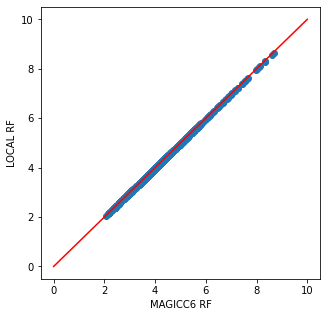

In [57]:
plt.figure(figsize=(5,5))
plt.scatter(MR,LR)
plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),c='red')
plt.xlabel("MAGICC6 RF")
plt.ylabel("LOCAL RF")

## Train multivariate linear regression to fit effect of other gases

In [58]:
dfp['RF3'] = dfp['Diagnostics|MAGICC6|Forcing|CO2'] + dfp['Diagnostics|MAGICC6|Forcing|CH4'] + dfp['Diagnostics|MAGICC6|Forcing|N2O'] 
dfp['RFD'] = dfp['Diagnostics|MAGICC6|Forcing'] - dfp['RF3']

In [59]:
d = dfp[dfp.RF3 < 6][['Diagnostics|MAGICC6|Concentration|CO2','Diagnostics|MAGICC6|Concentration|CH4','Diagnostics|MAGICC6|Concentration|N2O','RFD']].dropna().values
X = d[:,0:3]
y = d[:,3]
rflr = LinearRegression()
rflr.fit(X,y)

def RF_cMAGICC(C,M,N):
    try:
        X_in = np.array([[x,M,N] for x in C])
    except:
        X_in = np.array([[C,M,N]])
    (x,y,z,r) = RF_MAGICC(C,M,N)
    d = rflr.predict(X_in)
    return  d + r

def RF_MAGICC_CORR(C,M,N):
    
    X_in = np.stack((C,M,N),axis=1)
    (x,y,z,r) = RF_MAGICC(C,M,N)
    d = rflr.predict(X_in)
    return  d + r

## Modeling Emission Scenarios and Atmospheric GHG Levels

In [60]:
fao_emissions_2019['Model:T'] = fao_emissions_2019['Total emissions without land use']
fao_emissions_2019['Model:A'] = fao_emissions_2019['Agriculture total']
fao_emissions_2019['Model:N'] = fao_emissions_2019['Model:T'] - fao_emissions_2019['Model:A']
fao_emissions_2019.loc['CO2 emissions','Model:L'] = livestock_data.sum()['Emissions|CO2|Livestock'] 
fao_emissions_2019.loc['CH4 emissions','Model:L'] = livestock_data.sum()['Emissions|CH4|Livestock'] 
fao_emissions_2019.loc['N2O emissions','Model:L'] = livestock_data.sum()['Emissions|N2O|Livestock'] 
fao_emissions_2019['Model:C'] = fao_emissions_2019['Model:A'] - fao_emissions_2019['Model:L']

fao_emissions_2019.loc['CO2 emissions','Model:R'] = livestock_data.sum()['Emissions|CO2|Soy Replacement']  
fao_emissions_2019.loc['CH4 emissions','Model:R'] = livestock_data.sum()['Emissions|CH4|Soy Replacement'] 
fao_emissions_2019.loc['N2O emissions','Model:R'] = livestock_data.sum()['Emissions|N2O|Soy Replacement'] 

In [61]:
fao_emissions_2019

,Agricultural land use,Agriculture and related land use,Agriculture total,Energy,Industrial processes and product use,International Bunkers,Other n.e.c.,Total emissions with agricultural land use,Total emissions without land use,Waste,Total without agriculture,Model:T,Model:A,Model:N,Model:L,Model:C,Model:R
Element,,,,,,,,,,,,,,,,,
CH4 emissions,14.994908,157.114485,142.119577,138.669712,0.491597,0.074555,0.000048,367.996193,353.001285,71.645796,210.881709,353.001285,142.119577,210.881709,122.710376,19.409201,0.035133
CO2 emissions,4.531875,4.531875,0.000000,32.780115,2.868140,1.037626,0.000014,41.235730,36.703855,0.017960,36.703855,36.703855,0.000000,36.703855,1.563234,-1.563234,0.772916
N2O emissions,0.220866,8.048989,7.828124,0.984436,0.787983,0.027850,0.565777,10.816570,10.595705,0.401535,2.767581,10.595705,7.828124,2.767581,6.993379,0.834745,0.110417


In [62]:
model_years = np.arange(2020,2200)

halflife = {
    'CO2': 1000,
    'CH4': 9,
    'N2O': 115
}

annualdecay = {
    'CO2': 1,
    'CH4': np.power(.5,1/halflife['CH4']),
    'N2O': np.power(.5,1/halflife['N2O'])
}

nona = {
    'CO2' : 0,
    'CH4' : (1-annualdecay['CH4']) * 717.76,
    'N2O' : (1-annualdecay['N2O']) * 269.55
}

# adjusted to fit with MAGICC projections
nona_fit = {
    'CO2' : 0,
    'CH4' : 25,
    'N2O' : 1.0 # 1.63 fits historical data
}

to_atm = {
    'CO2' : .5,
    'CH4' : 1,
    'N2O' : 1
}

to_Mt = {
    'CO2' : 1000,
    'CH4' : 1,
    'N2O' : 1
}

pp_scale = {
    'CO2' : (1/1000),
    'CH4' : 1,
    'N2O' : 1
}

mw = {
    'CO2' : 44,
    'CH4' : 16,
    'N2O' : 44
}

pp_start = {
    'CO2': 409.819034,
    'CH4': 1863.93445,
    'N2O': 332.538751
}

groups = {
    'bovids' : ['cattle_meat','cow_milk','buffalo_meat','buffalo_milk'],
    'ruminants' : ['cattle_meat','buffalo_meat','goat_meat','sheep_meat','cow_milk','buffalo_milk','goat_milk','sheep_milk'],
    'ruminant_meat' : ['cattle_meat','buffalo_meat','goat_meat','sheep_meat'],
    'ruminant_milk' : ['cow_milk','buffalo_milk','goat_milk','sheep_milk'],
    'poultry' : ['chicken_meat','eggs']
}

for cat in commodity_info.Category.unique():
    groups[cat] = [cat]


# Amount of carbon Hayek et al. estimate would be fixed over 30 years with a transformation to a plant only diet

# Reported in gigatonnes C

c_oc = 216

# convert gigatonnes C to gigatonnes CO2

co2_oc = c_oc * 44 / 12

land_use_total = livestock_data.sum()['Land Use']

In [63]:
fao_emissions_2019

,Agricultural land use,Agriculture and related land use,Agriculture total,Energy,Industrial processes and product use,International Bunkers,Other n.e.c.,Total emissions with agricultural land use,Total emissions without land use,Waste,Total without agriculture,Model:T,Model:A,Model:N,Model:L,Model:C,Model:R
Element,,,,,,,,,,,,,,,,,
CH4 emissions,14.994908,157.114485,142.119577,138.669712,0.491597,0.074555,0.000048,367.996193,353.001285,71.645796,210.881709,353.001285,142.119577,210.881709,122.710376,19.409201,0.035133
CO2 emissions,4.531875,4.531875,0.000000,32.780115,2.868140,1.037626,0.000014,41.235730,36.703855,0.017960,36.703855,36.703855,0.000000,36.703855,1.563234,-1.563234,0.772916
N2O emissions,0.220866,8.048989,7.828124,0.984436,0.787983,0.027850,0.565777,10.816570,10.595705,0.401535,2.767581,10.595705,7.828124,2.767581,6.993379,0.834745,0.110417


# Scenario Modeling

The core scenario model is simple:

#### Convert emissions to atmospheric levels

CH4 and N2O go straight to atmosphere, CO2 we assume 50% goes to sinks. This approach was confirmed with fits to historical data. The conversion factor is based on mass and number of moles of gas in atmosphere. 

#### Decay of $CH_4$ and $N_{2}O$

There is some variance in estimates for the atmospheric half-lives of $CH_4$ (range 9-12) and $N_{2}O$ (range 115-121). We went with the lower values because these fit historical data better but they do not have significant impacts on the overall conclusions.

#### Non-anthropogenic emissions

Following other models, we assume that there is a non-anthropogenic contribution from $CH_4$ and $N_{2}O$. The values used were determined by fits to historical data.

In [64]:
def RunScenarios(emissions,
                to_Mt = to_Mt,
                mw = mw,
                pp_scale = pp_scale,
                pp_start = pp_start,
                annualdecay = annualdecay,
                to_atm = to_atm,
                nona = nona_fit
                ):
    concentration = {}
    for gas in gases:
        p = emissions[gas] * to_Mt[gas] * 1.0E12 * (1/mw[gas]) * (1/1.8E11) * pp_scale[gas]
        a = np.zeros(len(emissions[gas]))
        a[0] = pp_start[gas]
        for i in range(1,len(a)):
            a[i] = a[i-1] * annualdecay[gas] + p[i-1] * to_atm[gas] + nona[gas]
        concentration[gas] = a
    return concentration

## Setup scenarios

In [65]:
scenarios = pd.DataFrame(data=model_years,columns=['Year'])

aa_phaseout = 15
scenarios['aa_exponential_phaseout'] = np.clip( np.exp (-5 * np.power((scenarios.Year-2020)/aa_phaseout,3)),0,1)

aa_phaseout_30 = 30
scenarios['aa_exponential_phaseout_30'] = np.clip( np.exp (-5 * np.power((scenarios.Year-2020)/aa_phaseout_30,3)),0,1)



co2_oc_burnin = 30

scenarios['CO2_recovery_elimination'] = 0
v = scenarios['CO2_recovery_elimination'].values
v[1] = 1
scenarios['CO2_recovery_elimination'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]

v = scenarios['aa_exponential_phaseout'].values
scenarios['aa_exponential_phaseout_delta'] = np.append([0],v[:-1]-v[1:])

v = scenarios['aa_exponential_phaseout_delta']
scenarios['CO2_recovery_phaseout'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]


v = scenarios['aa_exponential_phaseout_30'].values
scenarios['aa_exponential_phaseout_delta_30'] = np.append([0],v[:-1]-v[1:])

v = scenarios['aa_exponential_phaseout_delta_30']
scenarios['CO2_recovery_phaseout_30'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]



co2_oc_burnin = 50

scenarios['CO2_slow_recovery_elimination'] = 0
v = scenarios['CO2_slow_recovery_elimination'].values
v[1] = 1
scenarios['CO2_slow_recovery_elimination'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]
v = scenarios['aa_exponential_phaseout_delta']
scenarios['CO2_slow_recovery_phaseout'] = co2_oc * np.convolve(v,np.ones(co2_oc_burnin) / co2_oc_burnin,mode='full')[0:len(v)]

scenarios['net_zero'] = np.clip(1-(scenarios.Year-2030)/30,0,1)

In [66]:
fao_emissions_2019

,Agricultural land use,Agriculture and related land use,Agriculture total,Energy,Industrial processes and product use,International Bunkers,Other n.e.c.,Total emissions with agricultural land use,Total emissions without land use,Waste,Total without agriculture,Model:T,Model:A,Model:N,Model:L,Model:C,Model:R
Element,,,,,,,,,,,,,,,,,
CH4 emissions,14.994908,157.114485,142.119577,138.669712,0.491597,0.074555,0.000048,367.996193,353.001285,71.645796,210.881709,353.001285,142.119577,210.881709,122.710376,19.409201,0.035133
CO2 emissions,4.531875,4.531875,0.000000,32.780115,2.868140,1.037626,0.000014,41.235730,36.703855,0.017960,36.703855,36.703855,0.000000,36.703855,1.563234,-1.563234,0.772916
N2O emissions,0.220866,8.048989,7.828124,0.984436,0.787983,0.027850,0.565777,10.816570,10.595705,0.401535,2.767581,10.595705,7.828124,2.767581,6.993379,0.834745,0.110417


In [67]:
scenario_list = []

## BAU
## assume ongoing emissions remain at 2019 levels

scid = 'BAU'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:T']

In [68]:
## Baseline
## assume 0 emissions

scid = 'Baseline'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = 0

In [69]:
## Net Zero
## assume non-agricultural emissions are steady through 2030 then drop linearly to 0 in 2060
 
scid = 'Net Zero'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = scenarios['net_zero'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:N'] + fao_emissions_2019.loc['%s emissions' % gas]['Model:A']

In [70]:
## Elimination Model
## assume all animal ag is replaced immediately

scid = 'Elimination'
scenario_list.append(scid)

recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = recovered_land / land_use_total

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_recovery_elimination'] 

In [71]:
## 15 Year Phaseout

scid = 'Phaseout'
scenario_list.append(scid)

recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = recovered_land / land_use_total

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
    scenarios[emid] += scenarios['aa_exponential_phaseout'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:L']
    scenarios[emid] += (1 - scenarios['aa_exponential_phaseout']) * fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_recovery_phaseout'] 

In [72]:
## 15 Year Phaseout and Net Zero

scid = 'Phaseout|Net Zero'
scenario_list.append(scid)

recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = recovered_land / land_use_total

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = scenarios['net_zero'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
    scenarios[emid] += scenarios['aa_exponential_phaseout'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:L']
    scenarios[emid] += (1 - scenarios['aa_exponential_phaseout']) * fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_recovery_phaseout'] 
    

In [73]:
## 30Year Phaseout

scid = 'Phaseout30'
scenario_list.append(scid)

recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = recovered_land / land_use_total

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)    
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
    scenarios[emid] += scenarios['aa_exponential_phaseout_30'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:L']
    scenarios[emid] += (1 - scenarios['aa_exponential_phaseout_30']) * fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_recovery_phaseout_30'] 

In [74]:
## 15 Year Elimination and Phaseout of different combinations of effects

for tag,gas_reduce in [
    ['CO2',['CO2']],
    ['CH4',['CH4']],
    ['N2O',['N2O']],
    ['CO2_CH4',['CO2','CH4']],
    ['CO2_CH4_N2O',['CO2','CH4','N2O']],
    ['CO2_CH4_N2O_CR',['CO2','CH4','N2O','CR']],
    ['CR_Only',['CR']],
    
]:

    scid = 'Phaseout_Breakdown_%s' % tag
    scenario_list.append(scid)
    
    recovered_land = livestock_data.sum()['Land Use|Recovered']
    cr_rat = recovered_land / land_use_total

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)

        if gas in gas_reduce:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
            scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
            scenarios[emid] += scenarios['aa_exponential_phaseout'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:L']
            scenarios[emid] += (1 - scenarios['aa_exponential_phaseout']) * fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
        else:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:T']
            
        if 'CR' in gas_reduce:
            scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_recovery_phaseout'] 
            
            
    scid = 'Elimination_Breakdown_%s' % tag
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)

        if gas in gas_reduce:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
            scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
            scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
        else:
            scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:T']
            
        if 'CR' in gas_reduce:
            scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_recovery_elimination'] 

In [75]:
## 50 Year Biomass Recovery

    
recovered_land = livestock_data.sum()['Land Use|Recovered']
cr_rat = recovered_land / land_use_total

scid = 'Phaseout|Slow Recovery'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
    scenarios[emid] += scenarios['aa_exponential_phaseout'] * fao_emissions_2019.loc['%s emissions' % gas]['Model:L']
    scenarios[emid] += (1 - scenarios['aa_exponential_phaseout']) * fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_slow_recovery_phaseout'] 

scid = 'Elimination|Slow Recovery'
scenario_list.append(scid)

for gas in gases:
    emid = 'Emissions|%s|%s' % (gas,scid)
    scenarios[emid] = fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
    scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:R']
    scenarios[emid] -= (gas == "CO2") * cr_rat * scenarios['CO2_slow_recovery_elimination'] 

In [76]:
## Eliminate and Phaseout of Product Categories

for group in groups:
    
    ## Elimination
        
    dfs = livestock_data[livestock_data.Category.isin(groups[group])].sum(numeric_only=True,axis=0)
    lu_frac = dfs['Land Use|Recovered'] / livestock_data.sum()['Land Use']
    
    scid = 'Elimination|%s' % group
    scenario_list.append(scid)

    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] =  fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:L']
        scenarios[emid] -= dfs['Emissions|%s|Livestock' % gas]
        scenarios[emid] += dfs['Emissions|%s|Soy Replacement' % gas]
        scenarios[emid] -= (gas == "CO2") * lu_frac * scenarios['CO2_recovery_elimination'] 
    
    ## Phaseout
    
    scid = 'Phaseout|%s' % group
    scenario_list.append(scid)
    
    for gas in gases:
        emid = 'Emissions|%s|%s' % (gas,scid)
        scenarios[emid] =  fao_emissions_2019.loc['%s emissions' % gas]['Model:N']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:C']
        scenarios[emid] += fao_emissions_2019.loc['%s emissions' % gas]['Model:L']
        scenarios[emid] -= (1 - scenarios['aa_exponential_phaseout'])  * dfs['Emissions|%s|Livestock' % gas]
        scenarios[emid] += (1 - scenarios['aa_exponential_phaseout']) * dfs['Emissions|%s|Soy Replacement' % gas]
        scenarios[emid] -= (gas == "CO2") * lu_frac * scenarios['CO2_recovery_phaseout'] 

## Run Scenarios

In [77]:
scenarios = scenarios.reset_index()

In [78]:
passed = []

for scen in scenario_list:
        em = {}
        for gas in gases:
            em[gas] = scenarios['Emissions|%s|%s' % (gas,scen)].fillna(0).values

        p = RunScenarios(em)
        for gas in gases:
            scenarios['Concentration|%s|%s' % (gas,scen)] = p[gas]

        rf = RF_MAGICC(p['CO2'],p['CH4'],p['N2O'])
        scenarios['RF|%s' % scen] = rf[3]
        scenarios['CRF|%s' % scen] = np.cumsum(scenarios['RF|%s' % scen].values) 
        scenarios['RFD|%s' % scen] =  scenarios['RF|%s' % scen] -  scenarios['RF|BAU']
        scenarios['CRFD|%s' % scen] = np.cumsum(scenarios['RFD|%s' % scen].values) 
        
        scenarios['RFY|%s' % scen] = rf[3] * (5.1E+14/1E+12)
        scenarios['CRFY|%s' % scen] = np.cumsum(scenarios['RFY|%s' % scen].values) 
        scenarios['RFDY|%s' % scen] =  scenarios['RFY|%s' % scen] -  scenarios['RFY|BAU']
        scenarios['CRFDY|%s' % scen] = np.cumsum(scenarios['RFDY|%s' % scen].values) 

        rf = RF_MAGICC_CORR(p['CO2'],p['CH4'],p['N2O'])
        scenarios['RFC|%s' % scen] = rf 
        scenarios['CRFC|%s' % scen] = np.cumsum(scenarios['RFC|%s' % scen].values) 
        scenarios['RFCD|%s' % scen] =  scenarios['RFC|%s' % scen] -  scenarios['RFC|BAU']
        scenarios['CRFCD|%s' % scen] = np.cumsum(scenarios['RFCD|%s' % scen].values)
        
        scenarios['RFCY|%s' % scen] = rf[3] * (5.1E+14/1E+12)  
        scenarios['CRFCY|%s' % scen] = np.cumsum(scenarios['RFCY|%s' % scen].values) 
        scenarios['RFDCY|%s' % scen] =  scenarios['RFCY|%s' % scen] -  scenarios['RFCY|BAU']
        scenarios['CRFDCY|%s' % scen] = np.cumsum(scenarios['RFDCY|%s' % scen].values) 

## Calibration Scenarios

We calculate an annualized CO2 equivalent for cumulative RF changes by comparison to scenarios in which we start with BAU and remove CO2 emissions in different levels and then do a calibration to observed RF differences.

In [79]:
calib_scenarios = pd.DataFrame(data=model_years,columns=['Year'])
calib_scenario_list = []


## BAU

calib_scenario_list.append('BAU')

for gas in gases:
    calib_scenarios['Emissions|%s|BAU' % gas] = fao_emissions_2019.loc['%s emissions' % gas]['Model:T']


gtsteps = np.arange(1,70)

for i in gtsteps:
    scenid = 'BAU_m%02dGT' % i
    calib_scenario_list.append(scenid)
    for gas in gases:
        calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

    # account for 2020
    v = np.ones(len(calib_scenarios))
    v[0] = 0

    calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i

mtsteps = np.arange(10,1000,10)

for i in mtsteps:
    scenid = 'BAU_m%04dMT' % i
    calib_scenario_list.append(scenid)
    for gas in gases:
        calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

    # account for 2020
    v = np.ones(len(calib_scenarios))
    v[0] = 0

    calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i/1000

ktsteps = np.arange(100,1000,100)

for i in ktsteps:
    scenid = 'BAU_m%04dkT' % i
    calib_scenario_list.append(scenid)
    for gas in gases:
        calib_scenarios['Emissions|%s|%s' % (gas,scenid)] = calib_scenarios['Emissions|%s|BAU' % gas]

    # account for 2020
    v = np.ones(len(calib_scenarios))
    v[0] = 0

    calib_scenarios['Emissions|CO2|%s' % scenid] = calib_scenarios['Emissions|CO2|BAU'] - v * i/1000000



for scen in calib_scenario_list:
    em = {}
    for gas in gases:
        em[gas] = calib_scenarios['Emissions|%s|%s' % (gas,scen)]

    p = RunScenarios(em)
    for gas in gases:
        calib_scenarios['Concentration|%s|%s' % (gas,scen)] = p[gas]

    rf = RF_MAGICC(p['CO2'],p['CH4'],p['N2O'])
    calib_scenarios['RF|%s' % scen] = rf[3]
    calib_scenarios['RFD|%s' % scen] =  calib_scenarios['RF|%s' % scen] -  calib_scenarios['RF|BAU']
    calib_scenarios['CRFD|%s' % scen] = np.cumsum(calib_scenarios['RFD|%s' % scen].values) 

    rf = RF_MAGICC_CORR(p['CO2'],p['CH4'],p['N2O'])
    calib_scenarios['RFC|%s' % scen] = rf
    calib_scenarios['RFCD|%s' % scen] =  calib_scenarios['RFC|%s' % scen] -  calib_scenarios['RFC|BAU']
    calib_scenarios['CRFCD|%s' % scen] = np.cumsum(calib_scenarios['RFCD|%s' % scen].values)   

calib_scenarios = calib_scenarios.set_index('Year')

coc_calibrations = {
}

for year in np.arange(2020,2200):

    x = []
    y = []

    r = calib_scenarios.loc[year]
    for i in gtsteps:
        x.append(i)
        y.append(r['CRFD|BAU_m%02dGT' % i])
    for i in mtsteps:
        x.append(i/1000)
        y.append(r['CRFD|BAU_m%04dMT' % i])
    for i in ktsteps:
        x.append(i/1000000)
        y.append(r['CRFD|BAU_m%04dkT' % i])

    f = interp1d(y,x)
    try:
        pf = np.polyfit(y,x,2)
        z = np.poly1d(pf)
    except:
        z = np.poly1d([0])

    x = []
    y = []

    r = calib_scenarios.loc[year]
    for i in gtsteps:
        x.append(i)
        y.append(r['CRFCD|BAU_m%02dGT' % i])
    for i in mtsteps:
        x.append(i/1000)
        y.append(r['CRFCD|BAU_m%04dMT' % i])
    for i in ktsteps:
        x.append(i/1000000)
        y.append(r['CRFCD|BAU_m%04dkT' % i])

    fc = interp1d(y,x)
    
    try:
        pfc = np.polyfit(y,x,2)
        zc = np.poly1d(pfc)
    except:
        zc = np.poly1d([0])

    coc_calibrations[year] = [f,z,fc,zc]


/Users/eisen/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:628: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


In [80]:
scenarios = scenarios.set_index('Year')

## Apply calibration functions

In [81]:
def compute_aco2eq(s):
    r = []
    for year in s.index:
        if year in coc_calibrations:
            [f,z,fc,zc] = coc_calibrations[year]
            try:
                v = f(s[year])
                r.append(float(v))
            except:
                v = z(s[year])
                r.append(float(v))
        else:
            r.append(0)    
    return r

def compute_aco2eqc(s):
    r = []
    for year in s.index:
        if year in coc_calibrations:
            [f,z,fc,zc] = coc_calibrations[year]
            try:
                v = fc(s[year])
                r.append(float(v))
            except:
                v = zc(s[year])
                r.append(float(v))
        else:
            r.append(0)    
    return r

In [82]:
for scen in scenario_list:
    scenarios['ACO2EQ|%s' % scen] = compute_aco2eq(scenarios['CRFD|%s' % scen])
    scenarios['COC|%s' % scen] = (scenarios.index - 2021) * scenarios['ACO2EQ|%s' % scen]
    scenarios['ACO2EQC|%s' % scen] = compute_aco2eqc(scenarios['CRFCD|%s' % scen]) 
    scenarios['COCC|%s' % scen] = (scenarios.index - 2021) * scenarios['ACO2EQC|%s' % scen]
    

for scen in calib_scenario_list:
    calib_scenarios['ACO2EQ|%s' % scen] = compute_aco2eq(calib_scenarios['CRFD|%s' % scen])
    calib_scenarios['COC|%s' % scen] = (calib_scenarios.index - 2021) * calib_scenarios['ACO2EQ|%s' % scen]
    calib_scenarios['ACO2EQC|%s' % scen] = compute_aco2eqc(calib_scenarios['CRFCD|%s' % scen]) 
    calib_scenarios['COCC|%s' % scen] = (calib_scenarios.index - 2021) * calib_scenarios['ACO2EQC|%s' % scen]    

In [83]:
## 

ref_year = 2100
r = scenarios.loc[ref_year]

for scen in scenario_list:
    v = scenarios['RFD|%s' % scen].values
    scenarios['RFDI|%s' % scen] = np.append([0],v[:-1]-v[1:])
    scenarios['RY_RFDW|%s' % scen] = (scenarios['RFDI|%s' % scen] * (2101 - scenarios.index))/r['CRFD|%s' % scen]

In [84]:
## 

ref_year = 2100
r = calib_scenarios.loc[ref_year]

for scen in calib_scenario_list:
    v = calib_scenarios['RFD|%s' % scen].values
    calib_scenarios['RFDI|%s' % scen] = np.append([0],v[:-1]-v[1:])
    calib_scenarios['RY_RFDW|%s' % scen] = (calib_scenarios['RFDI|%s' % scen] * (2101 - calib_scenarios.index))/r['CRFD|%s' % scen]

## Product Equivalents

In [85]:
livestock_data['Dress Factor'] = 1.0
meat_cats = [c for c in livestock_data.Category.unique() if 'meat' in c]
df = livestock_data[livestock_data.Category.isin(meat_cats) ]
livestock_data.loc[df.index,'Dress Factor'] = 1.5
livestock_data['Dress Consumption'] = livestock_data['Consumption'] / livestock_data['Dress Factor']

In [86]:
livestock_data

,Area,Category,Domestic Production,Export Quantity,Import Quantity,Consumption,Emissions|CO2|Livestock|Domestic,Emissions|CH4|Livestock|Domestic,Emissions|N2O|Livestock|Domestic,Import Quantity Detailed,...,Land Use|Soy Replacement,Land Use|Recovered,Emissions|CO2|Soy Replacement,Emissions|CH4|Soy Replacement,Emissions|N2O|Soy Replacement,Emissions|CO2|Crop Replacement,Emissions|CH4|Crop Replacement,Emissions|N2O|Crop Replacement,Dress Factor,Dress Consumption
0,Brunei Darussalam,cow_milk,50.0,991.5,59242.5,58301.0,0.0,0.000002,0.0,59229.0,...,0.00002,0.000506,0.000018,0.000001,0.000003,-0.0,0.000241,0.00001,1.0,58301.0
1,Cambodia,cow_milk,24259.0,7482.0,77392.0,94169.0,0.000014,0.001038,0.000046,77396.0,...,0.000032,0.000873,0.000028,0.000001,0.000004,-0.0,0.000389,0.000017,1.0,94169.0
2,"China, Taiwan Province of",cow_milk,431879.0,6641.0,1281455.0,1706693.0,0.000257,0.018483,0.000818,1281453.0,...,0.000582,0.014412,0.000512,0.000023,0.000073,-0.0,0.007051,0.000303,1.0,1706693.0
3,"China, mainland",cow_milk,32012400.0,99186.0,13855143.5,45768357.5,0.019056,1.370003,0.060633,13855111.0,...,0.015612,0.390122,0.013738,0.000624,0.001963,-0.0,0.189077,0.008132,1.0,45768357.5
4,Democratic People's Republic of Korea,cow_milk,83346.0,0.0,28374.0,111720.0,0.00005,0.003567,0.000158,0.0,...,0.000038,0.000704,0.000034,0.000002,0.000005,-0.0,0.000462,0.00002,1.0,111720.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636,Slovenia,sheep_milk,570.0,0.0,0.0,570.0,0.0,0.000046,0.000001,0.0,...,0.0,0.000005,0.0,0.0,0.0,-0.0,0.000004,0.0,1.0,570.0
1637,Spain,sheep_milk,563530.0,0.0,0.0,563530.0,0.000396,0.045455,0.001264,0.0,...,0.000346,0.004662,0.000304,0.000014,0.000043,-0.0,0.004188,0.00018,1.0,563530.0
1638,Sweden,sheep_milk,0.0,1040.0,29930.0,28890.0,0.0,0.0,0.0,29940.0,...,0.000018,0.000248,0.000016,0.000001,0.000002,-0.0,0.000215,0.000009,1.0,28890.0
1639,Switzerland,sheep_milk,6500.0,0.0,0.0,6500.0,0.000005,0.000524,0.000015,0.0,...,0.000004,0.000054,0.000004,0.0,0.000001,-0.0,0.000048,0.000002,1.0,6500.0


In [87]:
# Emission Intensities
# per kg product

miles_per_gallon = 22.2
km_per_gallon = miles_per_gallon / 0.621371
km_per_liter = km_per_gallon / 3.78541

co2_per_gallon = 8.8
co2_per_liter = co2_per_gallon / 3.78541

km_per_kgco2 = km_per_liter / co2_per_liter

for group in groups:
    for scen in ['Elimination|%s' % group,'Phaseout|%s' % group]:
        
        df = livestock_data[livestock_data.Category.isin(groups[group])]
        scenarios['EI_perunit|%s' % scen] = (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * df['Dress Consumption'].sum())
        scenarios['DD_perunit|%s' % scen] = scenarios['EI_perunit|%s' % scen] * km_per_kgco2 
        scenarios['EI_perprotein|%s' % scen] = (1E+12 * scenarios['ACO2EQ|%s' % scen]) / (1000 * df['Protein Consumption'].sum())
        scenarios['DD_perprotein|%s' % scen] = scenarios['EI_perprotein|%s' % scen] * km_per_kgco2
        

In [88]:
scenarios.to_csv("Outputs/Scenarios.csv")
calib_scenarios.to_csv("Outputs/Calibration_Scenarios.csv")

## Emissions and Land Carbon Opportunity Cost

We extend the concept of COC (Hayek et al., 2021) to include both emissions and land use changes. We define the “emissions and land carbon opportunity cost” (ELCOC) of dietary interventions as the cumulative reduction in CO2 emissions necessary to reduce the RF projected in a BAU scenario in 2100 to the RF projected following intervention.  

We define the combined emissions and land carbon opportunity cost (ELCOC) of animal agriculture as $2\Delta C$ where:
  
$RF(C_{BAU}-\Delta C,M_{BAU},N_{BAU})=RF(C_{POD},M_{POD},N_{POD})$  

The factor of 2 accounts for the half of $CO_2$ emissions that go to terrestrial sinks.


In [89]:
proj_end = scenarios.loc[2100]

xl = 300
xh = 700
x = np.linspace(xl,xh,100000)

CB = proj_end['Concentration|CO2|BAU']
MB = proj_end['Concentration|CH4|BAU']
NB = proj_end['Concentration|N2O|BAU']

xd = x - CB
xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
x_R = RF_cMAGICC(x,MB,NB)

data = []

rft = proj_end['RFC|BAU']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Baseline',rft,xn])

rft = proj_end['RFC|Phaseout|bovids']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Phaseout Bovids',rft, xn])

rft = proj_end['RFC|Phaseout']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Phaseout',rft,xn])

rft = proj_end['RFC|Elimination']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Elimination',rft,xn])

rft = 2.6
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['RF2.6',rft,xn])

rft = 1.9
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['RF1.9',rft,xn])

elcoc = pd.DataFrame(data=data,columns=['Target','RF','ELCOC'])
elcoc['ELCOC'] = np.round(elcoc.ELCOC,2)
elcoc = elcoc.set_index(['Target'])

In [90]:
elcoc

,RF,ELCOC
Target,,
Baseline,4.878793,-0.00
Phaseout Bovids,4.045890,-1.30
Phaseout,3.773469,-1.69
Elimination,3.736982,-1.74
RF2.6,2.600000,-3.16
RF1.9,1.900000,-3.90


## Land Use if Western Diet Extended to Whole Planet

In [91]:
diet_countries = country_group[country_group['Country Group'] == "OECD"].Country

In [92]:
pop = pd.read_csv("FAOSTAT/Filtered/Population_E_All_Data_(Normalized).csv")

diet_pop = pop[(pop.Year == 2018) & (pop.Area.isin(diet_countries))].groupby('Element').sum().loc['Total Population - Both sexes']['Value'] * 1000
diet_pop_landuse = livestock_data[livestock_data.Area.isin(diet_countries)].sum(numeric_only=True)['Land Use']

world_pop = pop[(pop.Year == 2018) & (pop.Area.isin(fao_countries))].groupby('Element').sum().loc['Total Population - Both sexes']['Value'] * 1000
world_pop_landuse = livestock_data[livestock_data.Area.isin(fao_countries)].sum(numeric_only=True)['Land Use']

scaled_land_use = diet_pop_landuse * world_pop / diet_pop
print ("If world had OECD diet and additional; %.2f Mkm^2 of land would be needed for livestock" % (scaled_land_use - world_pop_landuse))

If world had OECD diet and additional; 35.44 Mkm^2 of land would be needed for livestock


## Table 1

In [93]:
table1 = livestock_data.groupby('Category').sum().reset_index().merge(commodity_info,on='Category')

In [94]:
data = []

r = scenarios.loc[2050]
for cat in list(table1.Category):
    data.append([cat,
                 r['ACO2EQ|Elimination|%s' %cat],
                 r['EI_perunit|Elimination|%s' %cat],
                 r['EI_perprotein|Elimination|%s' %cat],
                 r['DD_perunit|Elimination|%s' %cat],
                ])

df = pd.DataFrame(data=data, columns=['Category','ACO2EQ','EI_perunit','EI_perprotein','DD'])

In [95]:
table1 = table1.merge(df,on="Category")

In [96]:
table1 = table1.set_index('Category')

In [97]:
table1.loc['buffalo_meat','Order'] = 1
table1.loc['cattle_meat','Order'] = 2
table1.loc['sheep_meat','Order'] = 3
table1.loc['goat_meat','Order'] = 4
table1.loc['pig_meat','Order'] = 5
table1.loc['chicken_meat','Order'] = 6
table1.loc['duck_meat','Order'] = 7
table1.loc['buffalo_milk','Order'] = 8
table1.loc['cow_milk','Order'] = 9
table1.loc['sheep_milk','Order'] = 10
table1.loc['goat_milk','Order'] = 11
table1.loc['eggs','Order'] = 12

table1 = table1.reset_index().sort_values(['Order'])

In [98]:
table1['Emissions|CO2'] = table1['Emissions|CO2|Livestock'] * 1000
table1['Emissions|CH4'] = table1['Emissions|CH4|Livestock']
table1['Emissions|N2O'] = table1['Emissions|N2O|Livestock']

In [99]:
table1 = table1[['Species', 'Product Type', 'Domestic Production', 'Protein Consumption',
                  'Emissions|CO2', 'Emissions|CH4', 'Emissions|N2O', 'Land Use', 
                'ACO2EQ', 'EI_perunit', 'EI_perprotein','DD']]

In [100]:
table1.to_csv("Outputs/Table1.csv", index=False)

table1

## Numbers from Text

### Abstract

These effects would yield a 30-year pause, from 2030 to 2060, in the rise of radiative forcing, a measure of the warming potential of the atmosphere, and a reduction in heat accumulation this century equivalent to a **25 gigaton** decrease in annual carbon dioxide emissions, over half of current anthropogenic emissions.

In [101]:
scenarios.loc[2100]['ACO2EQ|Phaseout']

24.984676390048914

### Significance Statement

The widespread use of animals to produce food has a massive negative impact on the climate, but the benefits of a global switch to a plant based diet are underappreciated. We show that eliminating greenhouse gas emissions from livestock, and allowing native habitats to regrow on the land currently used to house and feed them, would reduce global warming for the rest of this century by the same amount as a **70** percent reduction in the use of fossil fuels in energy and transportation. We hope that putting a number on the “climate opportunity cost” of our continued use of animals as food will help policymakers and the public properly prioritize dietary change as a climate defense strategy.  


In [102]:
scenarios.loc[2100]['ACO2EQ|Phaseout'] / (fao_emissions_2019.loc['CO2 emissions']['Energy'] + 34/1000 * fao_emissions_2019.loc['CH4 emissions']['Energy'])

0.666348929936755

### Results

#### Modeling the effect of eliminating animal agriculture on GHG levels

Based on this analysis, in 2019 (the most recent year for which full data are available), global production of animal-derived foods led to direct emissions of **1.6 Gt CO2**, due primarily to energy use (we excluded land clearing), **122 Mt CH4** due to enteric fermentation and manure management, and **7 Mt N2O** due primarily to fertilization of feed crops and manure management (Figure 1 and Figure 1-S1). These numbers are consistent with other recent estimates (Gerber et al., 2013; Steinfeld et al., 2006), and correspond, respectively, to **four** percent of CO2, **35** percent of CH4 and **66** percent of N2O emissions from all human activities. 

In [103]:
for gas in gases:
    emissions = livestock_data.sum()['Emissions|%s|Livestock' % gas]
    fraction = emissions / fao_emissions_2019.loc['%s emissions' % gas]['Model:T']
    print ("%4s %6.2f %.2f" % (gas,emissions,fraction))

 CO2   1.56 0.04
 CH4 122.71 0.35
 N2O   6.99 0.66


### Eliminating animal agriculture would achieve half of the emission reductions needed to meet Paris Agreement GHG targets 

By the end of the century the RF under the plant-only diet scenario would be **3.8 Wm-2** compared to **4.9** Wm-2 for BAU. To put this difference in perspective, phasing out animal agriculture over the next 15 years would reduce RF in 2100 by the same amount as eliminating 1,680 gigatons of CO2 emissions, the equivalent of **33** years of current anthropogenic emissions. 

In 2010, the climate modeling community defined a series of four “Representative Concentration Pathways” that capture a wide range of future warming scenarios, leading to 2100 RF levels of 8.5, 6.0, 4.5 and 2.6 Wm-2, respectively (Moss et al., 2010; van Vuuren et al., 2011). These model pathways were extended after the Paris Agreement to include a target of 1.9 Wm-2. Although the exact relationship between RF and global warming is complicated and incompletely understood, 2100 RF values of 1.9 and 2.6 Wm-2 are generally used as targets for limiting warming in this century to 1.5˚C and 2.0˚C, respectively, over the baseline pre-industrial global average temperature (IPCC, 2018).

The 1,680 gigaton CO2 equivalent reduction in RF from eliminating animal agriculture, would, without any other intervention to reduce GHG emissions, achieve **53** percent of the net GHG emissions reductions necessary to reach the 2100 RF target of 2.6 Wm-2 and **43** percent of the emissions reductions necessary to reach the 1.9 Wm-2 target 4 and Figure 4-S1). 

In [104]:
r = scenarios.loc[2100]

for scen in ['BAU','Phaseout']:
    print ("%-15s %5.2f" % (scen,r['RFC|%s' % scen]))

BAU              4.88
Phaseout         3.77


In [105]:
elcoc

,RF,ELCOC
Target,,
Baseline,4.878793,-0.00
Phaseout Bovids,4.045890,-1.30
Phaseout,3.773469,-1.69
Elimination,3.736982,-1.74
RF2.6,2.600000,-3.16
RF1.9,1.900000,-3.90


In [106]:
# number of years for Phaseout ELCOC

total_2019_emissions = 0
total_2019_emissions += fao_emissions_2019.loc['CO2 emissions']['Model:T']
total_2019_emissions += fao_emissions_2019.loc['CH4 emissions']['Model:T'] * 34 / 1000
total_2019_emissions += fao_emissions_2019.loc['N2O emissions']['Model:T'] * 298 / 1000

print ("Difference in RF in 2100 between BAU and Phaseout equivalent to %f years at 2019 rates" % (-elcoc.loc['Phaseout']['ELCOC'] * 1000 / total_2019_emissions))




Difference in RF in 2100 between BAU and Phaseout equivalent to 32.585588 years at 2019 rates


In [107]:
# Fraction to RF 2.6

elcoc.loc['Phaseout']['ELCOC'] / elcoc.loc['RF2.6']['ELCOC']

0.5348101265822784

In [108]:
# Fraction to RF 1.9

elcoc.loc['Phaseout']['ELCOC'] / elcoc.loc['RF1.9']['ELCOC']

0.43333333333333335

#### Eliminating animal agriculture would negate half of anthropogenic GHG emissions through 2100

Figure 5 shows the aCO2eq for both phaseout and elimination of animal agriculture in reference years 2050 and 2100. The aCO2eq2100 for a 15-year phaseout of animal agriculture is **-25.0** Gt/year, and the **-2,000** Gt total CO2eq equivalent emission are slightly more than half of all emissions expected under BAU (see also Figure 5-S1 which compares the emissions, atmospheric levels, and cumulative RF differences with BAU of phaseout and a 25 Gt/year CO2 decrease). 

Although the immediate elimination of animal agriculture is not realistic, analyzing the impact of such a shift paints the clearest picture of the climate costs of its continuation and the climate opportunity unlocked by its reduction or elimination. Unsurprisingly, a model in which all animal agriculture linked emissions are eliminated beginning in 2021 (Figure 2-S1), and the 30-year carbon recovery period begins immediately on all land currently used in animal agriculture, amplifies the effects seen with a 15-year phaseout. This leads to a much higher aCO2eq2050 for elimination (**-45.0** Gt/year) than phaseout (**-28.6** Gt/year). 

The **-2,290** Gt effective total emissions through 2100 inferred from the aCO2eq2100 for immediate livestock elimination of -28.6 Gt/year represents our best estimate of the full 21st century carbon opportunity cost of continuing to use animal agriculture as a technology for food production. 

In [109]:
cols = ['ACO2EQ|Phaseout','ACO2EQ|Elimination']
for c in cols:
    print ("%-20s %04.1f %04d %04.1f %04d" % (c,scenarios.loc[2050][c],scenarios.loc[2050][c]*30,scenarios.loc[2100][c],scenarios.loc[2100][c]*80))

ACO2EQ|Phaseout      26.7 0799 25.0 1998
ACO2EQ|Elimination   45.0 1350 28.6 2289


#### The climate impact of animal agriculture is dominated by ruminants, especially cattle

To analyze the climate impact of specific animal products, and to attribute these impacts on a per unit basis, we ran models in which we considered the immediate elimination and 15 year phaseout of individual animal products or groups of related products, using the species- and product-specific emissions and land use values described above (Figure 5; see also Table 1).  

Using aCO2eq2050 , the atmospheric warming potential through 2050, as our primary measure of product-specific effects, beef accounts for **47** percent of the benefits of phasing out all animal agriculture, and cow milk **24** percent. Collectively, meat and milk from bovids (cattle and buffalo) produce **80** percent of the benefits. Although they account for only 50 percent of animal-derived protein, ruminants (cattle, buffalo, sheep and goats) collectively account for **90** percent of the aCO2eq2050 of all livestock. 

Because aCO2eq for elimination compares the effects of persistent changes in animal agriculture to persistent changes in CO2 emissions, it can be interpreted on a per unit basis (Figure 6). Ruminant meat has, by far, the greatest per-unit climate impact, with a production-volume weighted average of **456** kg aCO2eq2050 per kg of consumer product, and 2019 kg aCO2eq2050 per kg protein. While cow milk has relatively low equivalent emissions per unit volume,  15.2 kg aCO2eq2050 per liter, its per-protein equivalent emissions are also high at 450 kg aCO2eq2050 per kg protein. 

To put these numbers in perspective, we converted the aCO2eq to the distance one would have to drive a typical car to produce the same emissions (Figure 6C). The aCO2eq2050 for a kg of beef of 469 kg per year, for example, is equivalent to driving **1,905** km in a typical US car (Bureau of Transportation Statistics, 2021). 

In [110]:
r = scenarios.loc[2050]
print ("%-16s %5.2f %4.3f" % ("ALL",r['ACO2EQ|Elimination'],1.0))

d = r['ACO2EQ|Elimination']

numlist = list(groups.keys()) + ['cattle_meat','cow_milk']
for group in numlist:
    n = r['ACO2EQ|Elimination|%s' % group]
    print ("%-16s %5.2f %4.3f" % (group,n,n/d))
    

ALL              45.02 1.000
bovids           35.91 0.798
ruminants        40.50 0.900
ruminant_meat    26.72 0.594
ruminant_milk    14.13 0.314
poultry           2.08 0.046
buffalo_meat      1.58 0.035
cattle_meat      21.25 0.472
chicken_meat      1.34 0.030
duck_meat         0.10 0.002
goat_meat         1.16 0.026
sheep_meat        2.85 0.063
pig_meat          2.57 0.057
buffalo_milk      2.64 0.059
cow_milk         10.76 0.239
goat_milk         0.39 0.009
sheep_milk        0.36 0.008
eggs              0.74 0.016
cattle_meat      21.25 0.472
cow_milk         10.76 0.239


In [111]:
r = scenarios.loc[2050]

numlist = list(groups.keys()) + ['cattle_meat','cow_milk']
for group in numlist:
    n = r['EI_perunit|Elimination|%s' % group]
    n2 = r['EI_perprotein|Elimination|%s' % group]
    print ("%-16s %8.2f %8.2f" % (group,n,n2))
    

bovids              40.33   910.06
ruminants           43.55   942.79
ruminant_meat      455.88  2019.54
ruminant_milk       16.22   475.28
poultry             12.26    73.43
buffalo_meat       553.68  2557.48
cattle_meat        469.40  2036.22
chicken_meat        16.50    77.21
duck_meat           20.40    95.43
goat_meat          284.29  1410.16
sheep_meat         444.99  2105.32
pig_meat            35.00   177.73
buffalo_milk        19.70   584.28
cow_milk            15.19   450.50
goat_milk           20.78   554.53
sheep_milk          34.93   575.79
eggs                 8.37    67.52
cattle_meat        469.40  2036.22
cow_milk            15.19   450.50


In [112]:
r = scenarios.loc[2050]

numlist = list(groups.keys()) + ['cattle_meat','cow_milk']
for group in numlist:
    n = r['DD_perunit|Elimination|%s' % group]
    print ("%-16s %8.2f" % (group,n))
    

bovids             163.73
ruminants          176.82
ruminant_meat     1850.86
ruminant_milk       65.83
poultry             49.78
buffalo_meat      2247.89
cattle_meat       1905.75
chicken_meat        67.00
duck_meat           82.81
goat_meat         1154.19
sheep_meat        1806.63
pig_meat           142.11
buffalo_milk        79.99
cow_milk            61.67
goat_milk           84.35
sheep_milk         141.80
eggs                33.99
cattle_meat       1905.75
cow_milk            61.67


In [136]:
food_supply

,Total,Animals,Seafood,Crops,Livestock,Livestock Fraction
Item,,,,,,
Calories,2884.00,514.00,34.00,2370.00,480.00,0.168421
Protein,81.23,32.13,5.22,49.10,26.91,0.354032
Fat,82.76,37.55,1.18,45.21,36.37,0.445820


In [114]:
soybean = 333671692 # tonnes
soybean_protein = 333671692 * .357
livestock_protein = 86824902.015235
soybean_ha = 120501628
land_ha = 13003000000
print ("%.2f %.5f" % (soybean_protein / livestock_protein, soybean_ha/land_ha))

1.37 0.00927


# Figures

## Figure Paramters

In [115]:
figw = 8.5
figh = 11

labelw = 100

cap_fontsize = 9

fc = .97
fc = 1.0
    
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend',fontsize=8)
plt.rc('axes',labelsize=9)
plt.rc('axes',titlesize=10)

## Figure 1 - Animal Ag Emissions and Land Use By Species

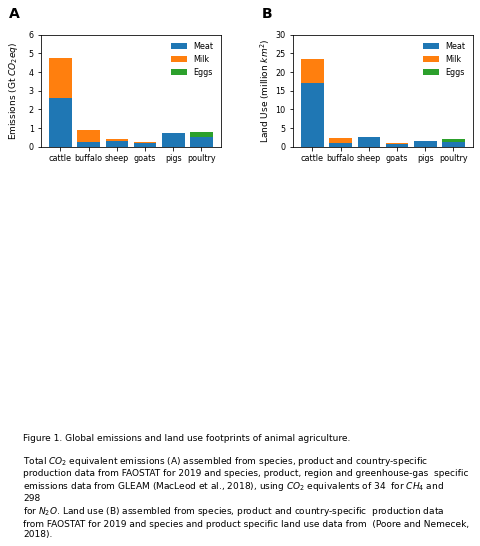

In [116]:
fignum = 1
pdffile = "Figures/Figure%d.pdf" % fignum


with PdfPages(pdffile) as pdf:    

    #figh = 6.0
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 2.5
    panelh = panelw/1.61
    
    label_pos = -.115
    
    margin_top = 3.0
    
    panelx1 = 1.25
    panelx2 = 4.75
    panely = figh - margin_top - panelh
    
    ax = fig.add_axes([panelx1/figw,panely/figh,panelw/figw,panelh/figh])
    
    df = livestock_data.groupby('Category').sum()
    df['Emissions'] = df['Emissions|CO2|Livestock'] + 34/1000 * df['Emissions|CH4|Livestock'] + 298/1000 * df['Emissions|N2O|Livestock']
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat'].Emissions,
        df.loc['buffalo_meat'].Emissions,
        df.loc['sheep_meat'].Emissions,
        df.loc['goat_meat'].Emissions,
        df.loc['pig_meat'].Emissions,
        df.loc['chicken_meat'].Emissions + df.loc['duck_meat'].Emissions,
        ])

    plot_milk = np.array([
        df.loc['cow_milk'].Emissions,
        df.loc['buffalo_milk'].Emissions,
        df.loc['sheep_milk'].Emissions,
        df.loc['goat_milk'].Emissions,
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'].Emissions,
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Emissions (Gt $CO_{2}eq$)', fontsize=9)
    ax.set_ylim(0,6)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.15,"A",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    margin_between = 1
    
    #panelx = (figw - panelw)/2
    #panely -= panelh + margin_between
    
    ax = fig.add_axes([panelx2/figw,panely/figh,panelw/figw,panelh/figh])
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat']['Land Use'],
        df.loc['buffalo_meat']['Land Use'],
        df.loc['sheep_meat']['Land Use'],
        df.loc['goat_meat']['Land Use'],
        df.loc['pig_meat']['Land Use'],
        df.loc['chicken_meat']['Land Use'] + df.loc['duck_meat']['Land Use'], 
    ])

    plot_milk = np.array([
        df.loc['cow_milk']['Land Use'],
        df.loc['buffalo_milk']['Land Use'],
        df.loc['sheep_milk']['Land Use'],
        df.loc['goat_milk']['Land Use'],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs']['Land Use'],
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Land Use (million $km^2$)')
    ax.set_ylim(0,30)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.15,"B",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    
    flh = r"Figure %d. Global emissions and land use footprints of animal agriculture." % fignum
    
    flt = r'''Total $CO_2$ equivalent emissions (A) assembled from species, product and country-specific 
production data from FAOSTAT for 2019 and species, product, region and greenhouse-gas 
specific emissions data from GLEAM (MacLeod et al., 2018), using $CO_2$ equivalents of 34 
for $CH_4$ and 298 for $N_{2}O$. Land use (B) assembled from species, product and country-specific 
production data from FAOSTAT for 2019 and species and product specific land use data from 
(Poore and Nemecek, 2018). 
'''
    
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

## Figure 2 - Comparing Baseline, Phaseout of Bovids and Phaseout of all Livestock 

Function creates different versions for different subsets of data

In [117]:
def Figure2(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 2
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - margin_top - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }
        
        gas_label = {
            'CO2' : r"$CO_2$",
            'CH4' : r"$CH_4$",
            'N2O' : r"$N_{2}O$"
        }
            
            
        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen2)],c='green',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen2)],c='green', linestyle='dashed')

            title = gas_label[gas] + " Emissions"
            ax[ai][0].set_title(title , fontsize=8)
            title = gas_label[gas] + " Atmospheric Concentration"
            ax[ai][1].set_title(title , fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,3):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,3):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)          


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2, linestyle='dashed'),
                Line2D([0],[0],color='green', lw=2),
            ]
    
            legend_labels = [
                'Business as Usual',
                scen2label,
                scenlabel,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(0,-.40), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
        #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

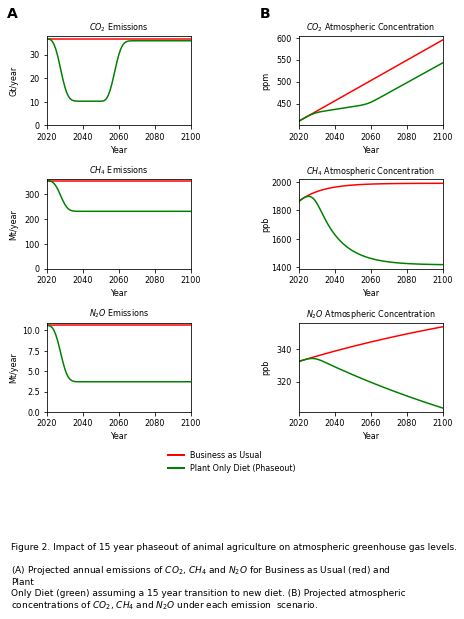

In [118]:
fignum = 2
plotname = "Figure%d" % fignum
plotlabel = r"Figure %d. Impact of 15 year phaseout of animal agriculture on atmospheric greenhouse gas levels." % fignum
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as Usual (red) and 
Plant Only Diet (green) assuming a 15 year transition to new diet. (B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission 
scenario.''' 

plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

#scen = "Elimination"
#scenlabel = "Plant Only Diet (Immediate Transition)"
scen = "Phaseout"
scenlabel = "Plant Only Diet (Phaseout)"


Figure2(plotname,plotlabel,plotcaption,scen,scenlabel)

## RF

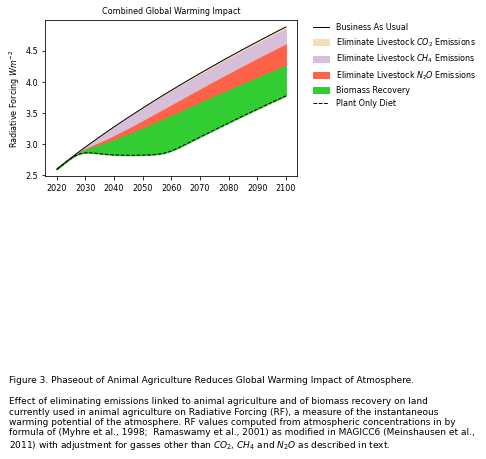

In [119]:
fignum = 3
pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    df = scenarios.loc[2020:2100]
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 4

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    

    l1 = ax.plot(df.index,df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
    fb1 = ax.fill_between(df.index,df['RFC|BAU'],df['RFC|Phaseout_Breakdown_CO2'],label=r'Eliminate Livestock $CO_2$ Emissions',color='wheat')
    fb2 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2'],df['RFC|Phaseout_Breakdown_CO2_CH4'],label=r'Eliminate Livestock $CH_4$ Emissions',color='thistle')
    fb3 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4'],df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],label=r'Eliminate Livestock $N_{2}O$ Emissions',color='tomato')
    fb4 =ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],df['RFC|Phaseout'],label='Biomass Recovery',color='limegreen')
    l2 = ax.plot(df.index,df['RFC|Phaseout'],color='black',linestyle='dashed',label='Plant Only Diet',linewidth=1)
    df = calib_scenarios.loc[2020:2100]
    #ax.plot(df['RFC|BAU_m28GT'],c='gray',linestyle='dashed',label=r'28Gt/year $CO_2$ reduction from BAU')
    ax.set_title("Combined Global Warming Impact", fontsize=8)

    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)       
    
    #ax.legend()
    
    ax.legend([l1[0],fb1,fb2,fb3,fb4,l2[0]],['Business As Usual',r'Eliminate Livestock $CO_2$ Emissions',r'Eliminate Livestock $CH_4$ Emissions',r'Eliminate Livestock $N_{2}O$ Emissions',
                                      'Biomass Recovery','Plant Only Diet'],bbox_to_anchor=(1.05,1.0), borderaxespad=0, frameon=False)
    
    flh = r"Figure 3. Phaseout of Animal Agriculture Reduces Global Warming Impact of Atmosphere."
    
    flt = r'''Effect of eliminating emissions linked to animal agriculture and of biomass recovery on land currently used
in animal agriculture on Radiative Forcing (RF), a measure of the instantaneous warming potential of the atmosphere.
RF values computed from atmospheric concentrations in by formula of (Myhre et al., 1998; 
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011) with adjustment for gasses other than
CO2, CH4 and N2O as described in text.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

## Figure 4 Carbon Opportunity for Eliminating Animal Ag

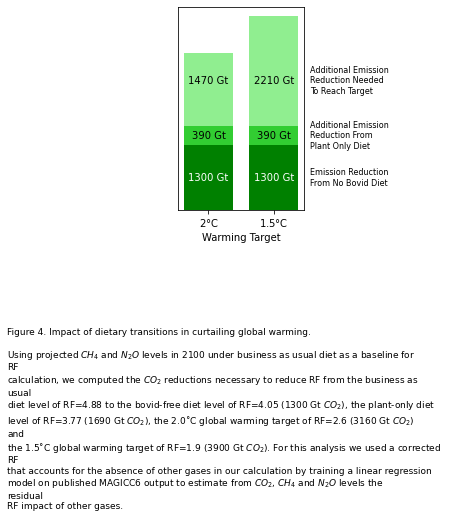

In [120]:
proj_end = scenarios.loc[2100]
fignum = 4

pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11

    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

   
    panelw = 1.75
    panelh = panelw * 1.61
    
    margin_top = 3

    panelx = (figw-panelw) / 2
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])


    # Data from Figure 3-S1 below
    
    labels = [r'2$\degree$C','1.5$\degree$C']
    
    ec = -elcoc.loc['Phaseout']['ELCOC']
    plant = np.array([ec,ec])
    ec = -elcoc.loc['Phaseout Bovids']['ELCOC']
    nobo = np.array([ec,ec])
    ec1 = -elcoc.loc['RF2.6']['ELCOC']
    ec2 = -elcoc.loc['RF1.9']['ELCOC']
    rftarget = np.array([ec1,ec2])
    width=.75
    
    l1 = ax.bar(labels,1000 * rftarget,width=width,color='lightgreen',label="Additional Emission Reductions Required to Reach Warming Target")
    l2 = ax.bar(labels,1000 * plant,width=width,color='limegreen',label='Additional Emission Reductions From Plant Only Diet')
    l3 = ax.bar(labels,1000 * nobo,width=width,color='green',label='Emission Reductions From No Bovid Diet')
    
    #ax.set_ylabel(r"$CO_{2}$ Emissions Reductions Gt",fontsize=10)
    
    ax.set_xticks(np.arange(0,len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    #ax.legend(bbox_to_anchor=(1,1.25), borderaxespad=0,fontsize=9,frameon=False)
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    ax.yaxis.set_label_coords(-1.5 * .075,0.5)
    ax.set_xlabel("Warming Target",fontsize=10)
    ax.set_yticklabels([])
    ax.set_yticks([])
    

# Add the patch to the Axes

    flh = "Figure %d. Impact of dietary transitions in curtailing global warming." % fignum
    
    flt = r'''Using projected CH4 and N2O levels in 2100 under business as usual diet
as a baseline for RF calculation, we computed the CO2 reductions necessary
to reduce RF from the business as usual diet level of RF=%.2f to the bovid-free diet
level of RF=%.2f (%d Gt CO2), the plant-only diet level of RF=%.2f (%d Gt CO2),
the 2.0˚C global warming target of RF=2.6 (%d Gt CO2) and the 1.5˚C global warming
target of RF=1.9 (%d Gt CO2). For this analysis we used a corrected RF that accounts
for the absence of other gases in our calculation by training a linear
regression model on published MAGICC6 output to estimate from CO2, CH4 and N2O
levels the residual RF impact of other gases. ''' % (
        elcoc.loc['Baseline']['RF'],
        elcoc.loc['Phaseout Bovids']['RF'],
        -elcoc.loc['Phaseout Bovids']['ELCOC'] * 1000,
        elcoc.loc['Phaseout']['RF'],
        -elcoc.loc['Phaseout']['ELCOC'] * 1000,
        -elcoc.loc['RF2.6']['ELCOC'] * 1000,
        -elcoc.loc['RF1.9']['ELCOC'] * 1000,
    )
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    
    #annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=40)

    #plt.figtext(1/figw, (figh - 1)/figh, annot_txt, horizontalalignment='left', verticalalignment='top', fontsize=cap_fontsize, multialignment='left', wrap="True")    
    
    v1 = -elcoc.loc['Phaseout Bovids']['ELCOC'] * 1000
    h1 = v1/2
    
    ax.text(1.55,h1,"Emission Reduction\nFrom No Bovid Diet",fontsize=8, verticalalignment='center')
    vlab = "%d Gt" % (v1)
    ax.text(0,h1,vlab,horizontalalignment='center',color='white',verticalalignment='center')
    ax.text(1,h1,vlab,horizontalalignment='center',color='white',verticalalignment='center')
    
    
    v2 = -elcoc.loc['Phaseout']['ELCOC'] * 1000
    h2 = v1 + 0.5 * (v2 - v1)
    
    ax.text(1.55,h2,"Additional Emission\nReduction From\nPlant Only Diet",fontsize=8, verticalalignment='center')
    vlab = "%d Gt" % (v2 - v1)
    ax.text(0,h2,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    ax.text(1,h2,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    
    
    v3 = -elcoc.loc['RF2.6']['ELCOC'] * 1000
    v4 = -elcoc.loc['RF1.9']['ELCOC'] * 1000
    
    h3 = v2 + 0.25 * (v3 - v2) + 0.25 * (v4 - v2)
    
    ax.text(1.55,h3,"Additional Emission\nReduction Needed\nTo Reach Target",fontsize=8, verticalalignment='center')
    vlab = "%d Gt" % (v3 - v2)
    ax.text(0,h3,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    vlab = "%d Gt" % (v4 - v2)
    ax.text(1,h3,vlab,horizontalalignment='center',color='black',verticalalignment='center')
    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)

##  Figure 5: ACO2EQ 

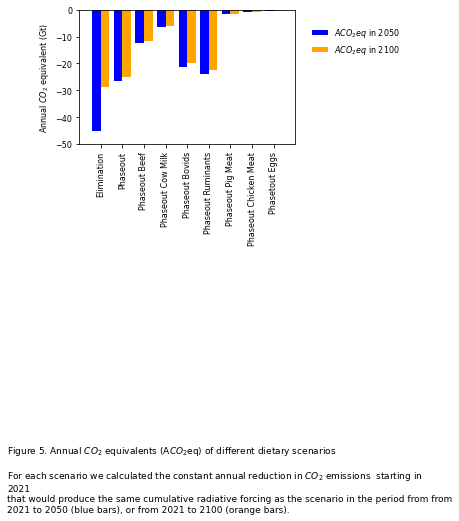

In [121]:
fignum = 5

pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf: 

    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))
    
    
    panelw = 3
    panelh = panelw/1.61
    
    margin_top = 3
    
    panelx = 2.0
    panely = figh - margin_top - panelh
    
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    plot_scenarios = ['Elimination','Phaseout','Phaseout|cattle_meat','Phaseout|cow_milk','Phaseout|bovids','Phaseout|ruminants','Phaseout|pig_meat','Phaseout|chicken_meat','Phaseout|eggs']
    plot_labels = ['Elimination','Phaseout','Phaseout Beef','Phaseout Cow Milk','Phaseout Bovids','Phaseout Ruminants','Phaseout Pig Meat','Phaseout Chicken Meat','Phasetout Eggs']

    x = np.arange(0,len(plot_scenarios))

    r = scenarios.loc[2050]
    y = [-r['ACO2EQ|%s'% s] for s in plot_scenarios]
    ax.bar(x-.2, y,.4,color='blue',label=r"$ACO_{2}eq$ in 2050")

    r = scenarios.loc[2100]
    y = [-r['ACO2EQ|%s'% s] for s in plot_scenarios]
    ax.bar(x+.2, y,.4,color='orange',label=r"$ACO_{2}eq$ in 2100")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels,rotation=90,fontsize=8)
    ax.set_ylabel(r"Annual $CO_2$ equivalent (Gt)",fontsize = 8)
    

    #ax.plot([-1,len(plot_scenarios)],[0,0],color='red',linestyle='dashed',linewidth=.1,label="Current Annual Emissions")
    ax.set_xlim(-1,len(plot_scenarios))
    ax.set_ylim(-50,0)
    
    plt.legend(bbox_to_anchor=(1.5,0.9), borderaxespad=0, frameon=False)
    
    flh = "Figure %d. Annual $CO_2$ equivalents (A$CO_2$eq) of different dietary scenarios" % fignum
    
    flt = r'''For each scenario we calculated the constant annual reduction in CO2 emissions 
starting in 2021 that would produce the same cumulative radiative forcing as the scenario in the
period from from 2021 to 2050 (blue bars), or from 2021 to 2100 (orange bars).'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")  
    
        
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)

###### Figure 5

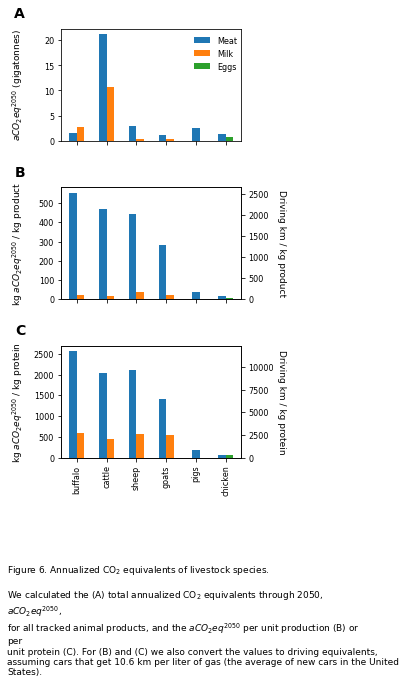

In [122]:
fignum = 6
pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 2.5
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = 1.75
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    bar_offset = .25
    bar_width = .25
    legend_x = .70
    label_x_offset = -.2
    
    bar_off_meat = np.array([-bar_width/2,-bar_width/2,-bar_width/2,-bar_width/2,0,-bar_width/2])
    bar_off_milk = np.array([bar_width/2,bar_width/2,bar_width/2,bar_width/2,0,0])
    bar_off_eggs = np.array([0,0,0,0,0,bar_width/2])
    
    r = scenarios.loc[2050]
    plot_species = ['buffalo','cattle','sheep','goats','pigs','chicken']

    x_labels = ['buffalo','cattle','sheep','goats','pigs','chicken']
    x_coords = np.array([1,2,3,4,5,6])

    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])

    meat_data = [
        r['ACO2EQ|Elimination|buffalo_meat'],
        r['ACO2EQ|Elimination|cattle_meat'],
        r['ACO2EQ|Elimination|sheep_meat'],
        r['ACO2EQ|Elimination|goat_meat'],
        r['ACO2EQ|Elimination|pig_meat'],
        r['ACO2EQ|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['ACO2EQ|Elimination|buffalo_milk'],
        r['ACO2EQ|Elimination|cow_milk'],
        r['ACO2EQ|Elimination|sheep_milk'],
        r['ACO2EQ|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['ACO2EQ|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
    pA1 = axA.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pA2 = axA.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pA3 = axA.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axA.set_ylabel(r'$aCO_2eq^{2050}$ (gigatonnes)')
    axA.text(label_x_offset,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks([1,2,3,4,5,6])
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(label_x_offset,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perunit|Elimination|buffalo_meat'],
        r['EI_perunit|Elimination|cattle_meat'],
        r['EI_perunit|Elimination|sheep_meat'],
        r['EI_perunit|Elimination|goat_meat'],
        r['EI_perunit|Elimination|pig_meat'],
        r['EI_perunit|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perunit|Elimination|buffalo_milk'],
        r['EI_perunit|Elimination|cow_milk'],
        r['EI_perunit|Elimination|sheep_milk'],
        r['EI_perunit|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perunit|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)
    
    
    pB1 = axB.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pB2 = axB.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pB3 = axB.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axB.set_ylabel(r'kg $aCO_2eq^{2050}$ / kg product')
    #axA.set_ylim(0,1.0)
    axB.text(label_x_offset,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks([1,2,3,4,5,6])
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(label_x_offset,0.5,transform=axB.transAxes)
    #axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axBt = axB.twinx()
    ymin = 0
    ymax = axB.get_ylim()[1]
    conv = (1.61 * 25) / 8.8  
    axBt.set_ylim(ymin,ymax*conv)
    axBt.set_ylabel(r'Driving km / kg product',rotation=-90)
    axBt.yaxis.set_label_coords(1.25,0.5,transform=axBt.transAxes)
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    meat_data = [
        r['EI_perprotein|Elimination|buffalo_meat'],
        r['EI_perprotein|Elimination|cattle_meat'],
        r['EI_perprotein|Elimination|sheep_meat'],
        r['EI_perprotein|Elimination|goat_meat'],
        r['EI_perprotein|Elimination|pig_meat'],
        r['EI_perprotein|Elimination|chicken_meat']
    ]
    meat_data = np.array(meat_data)
    
    milk_data = [
        r['EI_perprotein|Elimination|buffalo_milk'],
        r['EI_perprotein|Elimination|cow_milk'],
        r['EI_perprotein|Elimination|sheep_milk'],
        r['EI_perprotein|Elimination|goat_milk'],
        0,
        0
    ]
    milk_data = np.array(milk_data)
    
    egg_data = [
        0,
        0,
        0,
        0,
        0,
        r['EI_perprotein|Elimination|eggs'],
    ]
    egg_data = np.array(egg_data)    
    pC1 = axC.bar(x_coords + bar_off_meat,meat_data,width=bar_width,label='meat')
    pC2 = axC.bar(x_coords + bar_off_milk,milk_data,width=bar_width,label='milk')
    pC3 = axC.bar(x_coords + bar_off_eggs,egg_data,width=bar_width,label='eggs')
    
    axC.set_ylabel(r'kg $aCO_2eq^{2050}$ / kg protein')
    #axA.set_ylim(0,1.0)
    axC.text(label_x_offset,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks([1,2,3,4,5,6])
    axC.set_xticklabels([])
    axC.yaxis.set_label_coords(label_x_offset,0.5,transform=axC.transAxes)
    #axC.legend((pC1[0], pC2[0], pC3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(legend_x,1.0))
    
    axCt = axC.twinx()
    ymin = 0
    ymax = axC.get_ylim()[1]
    conv = (1.61 * 25) / 8.8  
    axCt.set_ylim(ymin,ymax*conv)
    axCt.set_ylabel(r'Driving km / kg protein',rotation=-90)
    axCt.yaxis.set_label_coords(1.25,0.5,transform=axCt.transAxes)
    panely -= panelh + panel_margin        
    axC.set_xticklabels(x_labels,rotation=90)
    
    flh = r"Figure %d. Annualized CO$_2$ equivalents of livestock species." % fignum
    
    flt = r'''We calculated the (A) total annualized CO$_2$ equivalents through 2050, $aCO_2eq^{2050}$, 
for all tracked animal products, and the $aCO_2eq^{2050}$ per unit production (B) or per unit protein (C).
For (B) and (C) we also convert the values to driving equivalents, assuming cars that get 10.6 km per liter of gas
(the average of new cars in the United States).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=90)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

## Figure 7 

In [123]:
dfp['SSP'] = dfp.Scenario.apply(lambda x: x.split('-')[0])
dfp['SSP-TARGET'] = dfp.Scenario.apply(lambda x: x.split('-')[1])

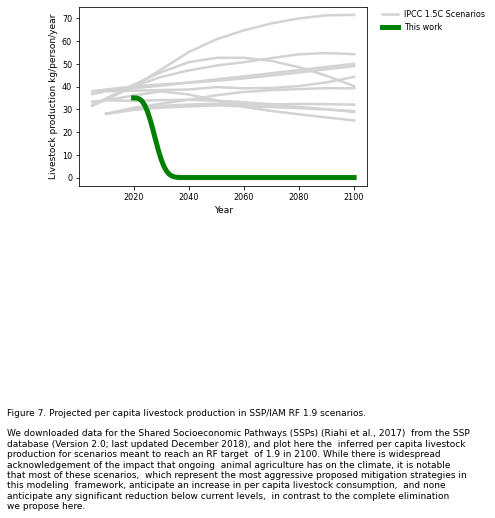

In [124]:
fignum = 7
pdffile = "Figures/Figure%d.pdf" % fignum

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 4
    panelh = panelw/1.61
    
    margin_top = 3
    
    panelx = 2.0
    panely = figh - margin_top - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    dfpw19 = dfp[(dfp.Region == "World") & (dfp['SSP-TARGET'] == '19')].copy()
    dfpw19.Year = dfpw19.Year.astype('int64')
    for i,r in dfpw19.groupby(['Model','Scenario']):
        ax.plot(r.Year,1e+3 * r['Agricultural Production|Livestock']/r['Population'],c='lightgrey',linewidth=2.5)
    
    r = scenarios.loc[2020:2100]
    ax.plot(r.aa_exponential_phaseout * 35, c='green', linewidth = 5)
    
    ax.set_xticks([2020,2040,2060,2080,2100])
    ax.set_xlabel("Year")
    ax.set_ylabel("Livestock production kg/person/year")
    
    legend_lines = [
        Line2D([0],[0],color='lightgrey', lw=2.5),
        Line2D([0],[0],color='green', lw=5),
    ]

    legend_labels = [
        'IPCC 1.5C Scenarios',
        'This work',
    ]

    plt.legend(legend_lines,legend_labels,bbox_to_anchor=(1.04,1.0), borderaxespad=0, frameon=False)

    
    flh = "Figure %d. Projected per capita livestock production in SSP/IAM RF 1.9 scenarios." % fignum
    
    flt = '''\
    We downloaded data for the Shared Socioeconomic Pathways (SSPs) (Riahi et al., 2017) 
    from the SSP database (Version 2.0; last updated December 2018), and plot here the 
    inferred per capita livestock production for scenarios meant to reach an RF target 
    of 1.9 in 2100. While there is widespread acknowledgement of the impact that ongoing 
    animal agriculture has on the climate, it is notable that most of these scenarios, 
    which represent the most aggressive proposed mitigation strategies in this modeling 
    framework, anticipate an increase in per capita livestock consumption, 
    and none anticipate any significant reduction below current levels, 
    in contrast to the complete elimination we propose here.
    '''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")
        
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    
    
    




# Supplemental Figures

## Figure 1-S1 - Animal Ag Emissions and Gas and Species

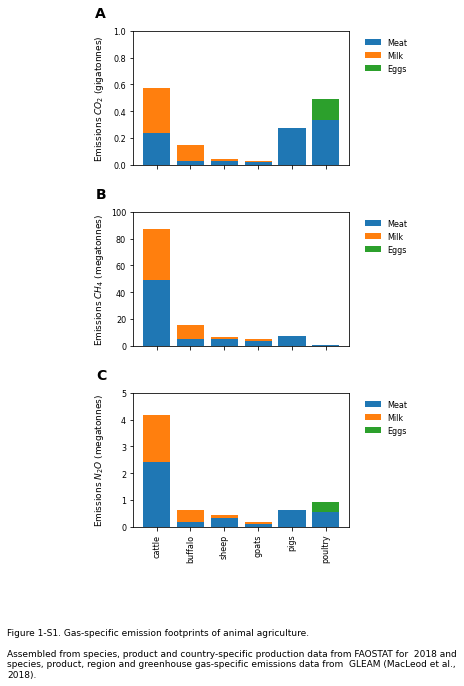

In [125]:
fignum = 1
supnum = 1
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 3
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = (figw - panelw)/2
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    df = livestock_data.groupby('Category').sum()
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    
    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CO2|Livestock" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pA1 = axA.bar(plot_species,plot_meat)
    pA2 = axA.bar(plot_species,plot_milk,bottom=plot_meat)
    pA3 = axA.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axA.set_ylabel(r"Emissions $CO_{2}$ (gigatonnes)")
    axA.set_ylim(0,1.0)
    axA.text(-.125,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks(np.arange(0,len(plot_species)))
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(-0.125,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CH4|Livestock" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pB1 = axB.bar(plot_species,plot_meat)
    pB2 = axB.bar(plot_species,plot_milk,bottom=plot_meat)
    pB3 = axB.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axB.set_ylabel(r"Emissions $CH_{4}$ (megatonnes)")
    axB.set_ylim(0,100)
    axB.text(-.125,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks(np.arange(0,len(plot_species)))
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(-0.125,0.5)
    axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left',frameon=False,bbox_to_anchor=(1.04,1.0))
   
    
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|N2O|Livestock" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    p1 = axC.bar(plot_species,plot_meat)
    p2 = axC.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = axC.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axC.set_ylabel(r"Emissions $N_{2}O$ (megatonnes)")
    axC.set_ylim(0,5)
    axC.text(-.125,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks(np.arange(0,len(plot_species)))
    axC.set_xticklabels(plot_species,rotation=90)
    axC.yaxis.set_label_coords(-0.125,0.5)
    axC.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))            
        
    
    flh = r"Figure %d-S%d. Gas-specific emission footprints of animal agriculture." % (fignum,supnum)
    
    flt = r'''Assembled from species, product and country-specific production data from FAOSTAT for 
2018 and species, product, region and greenhouse gas-specific emissions data from 
GLEAM (MacLeod et al., 2018).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    
    

In [126]:
def EmLeRF_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures_Supplements/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 1
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - 1 - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2,3]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }

        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen2)],c='green',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen2)],c='green', linestyle='dashed')

            ax[ai][0].set_title("Emissions " + gas, fontsize=8)
            ax[ai][1].set_title("Atmospheric Concentration " + gas, fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        ax[3][1].plot(r['RF|BAU'],c='red')
        ax[3][1].plot(r['RF|%s' %scen],c='green')
        if scen2 != "":
            ax[3][1].plot(r['RF|%s' %scen2],c='green',linestyle='dashed')
        ax[3][1].set_title("Combined Global Warming Impact", fontsize=8)
        ax[3][1].yaxis.set_label_coords(label_pos,0.5)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[3][1].text(label_pos,1.2,"C",transform=ax[3][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,4):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,4):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)

        ax[3][0].set_visible(False)
        ax[3][1].set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)                


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2, linestyle='dashed'),
                Line2D([0],[0],color='green', lw=2),
            ]
    
            legend_labels = [
                'Business as Usual',
                scen2label,
                scenlabel,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(-.75,.5), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
        #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

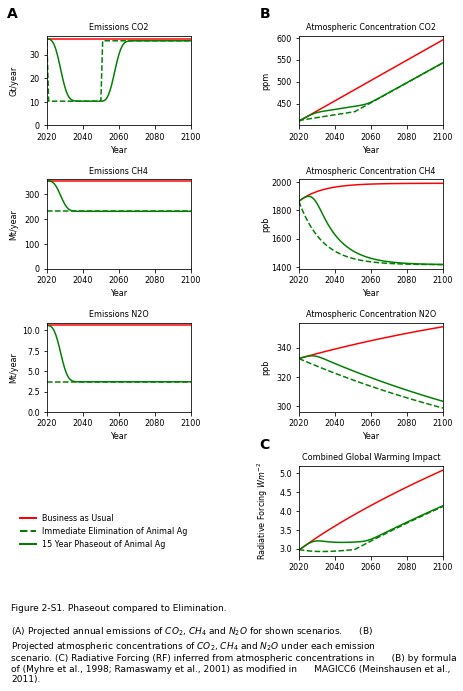

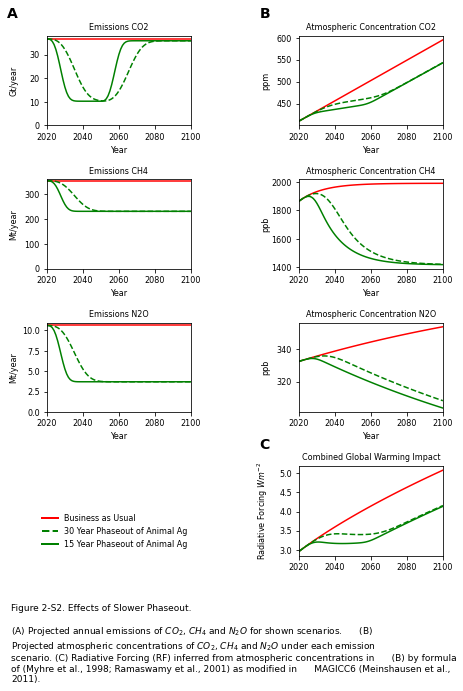

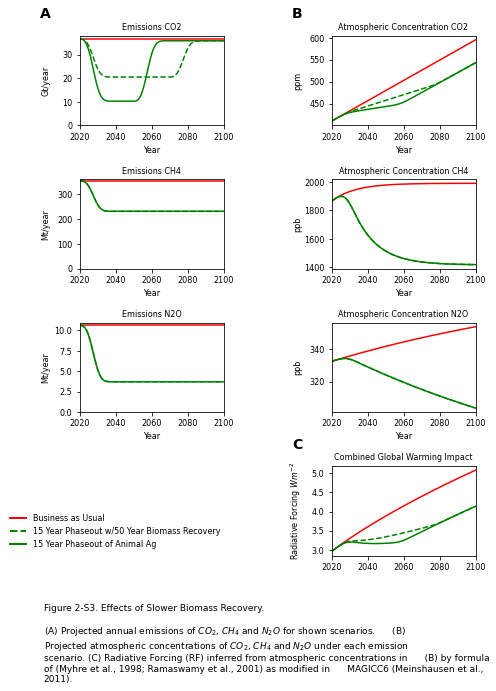

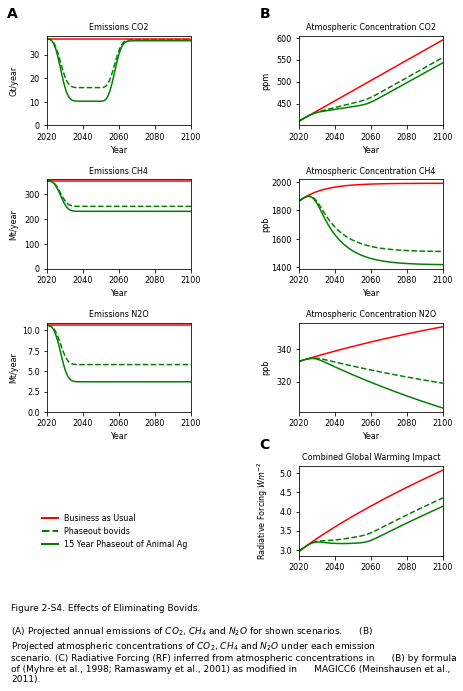

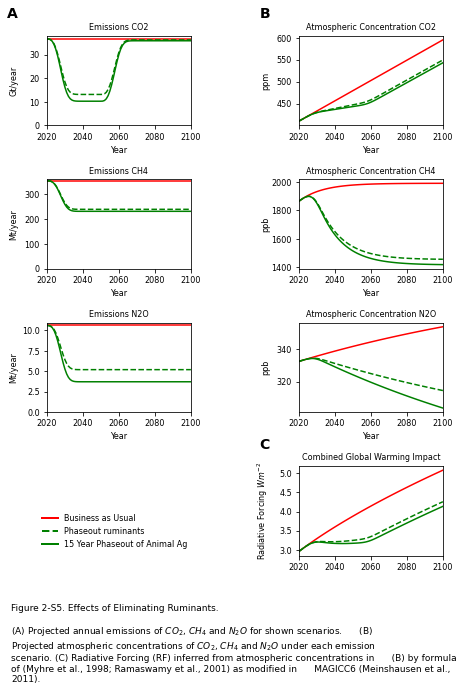

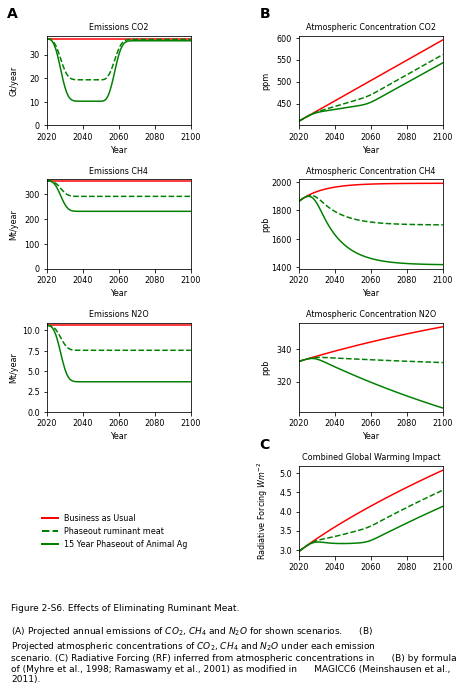

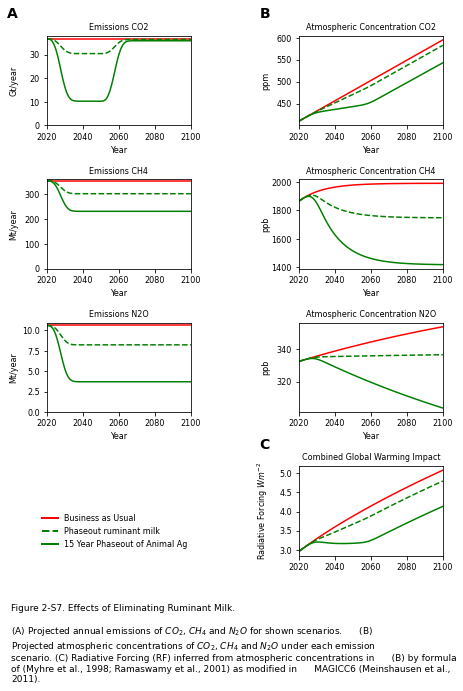

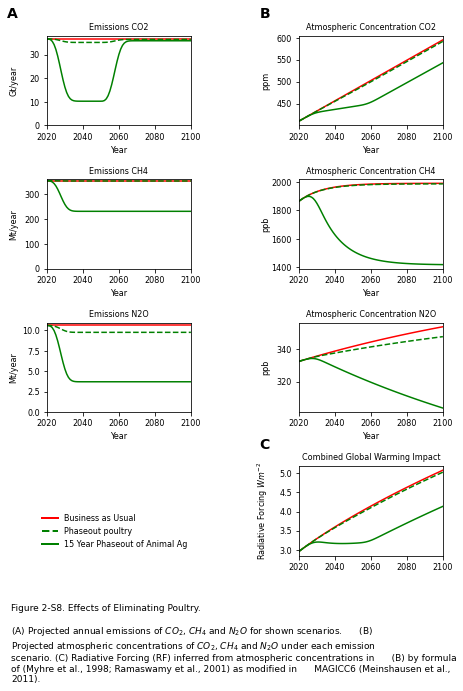

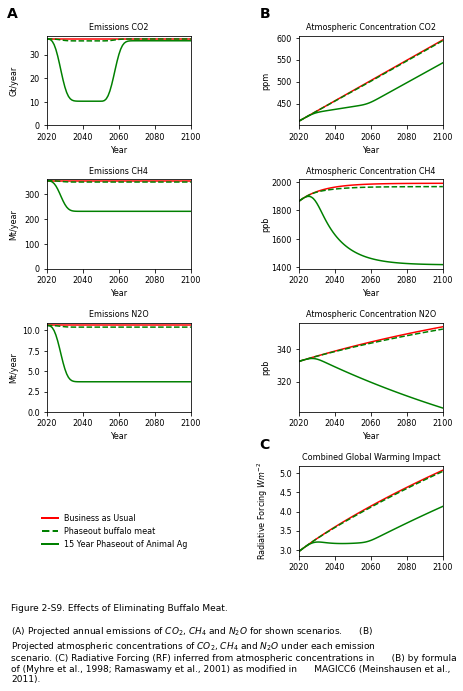

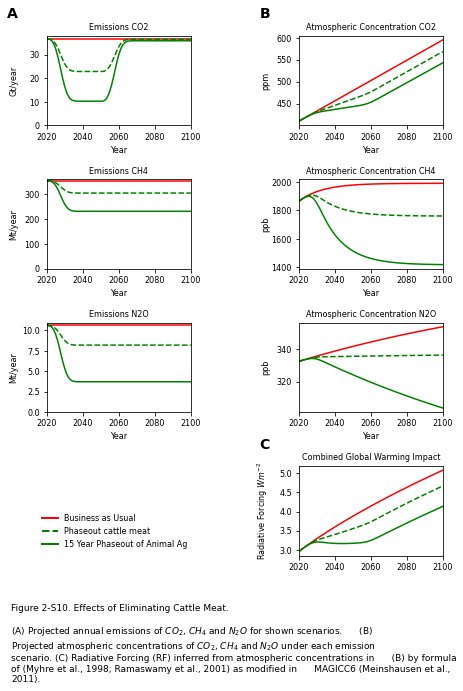

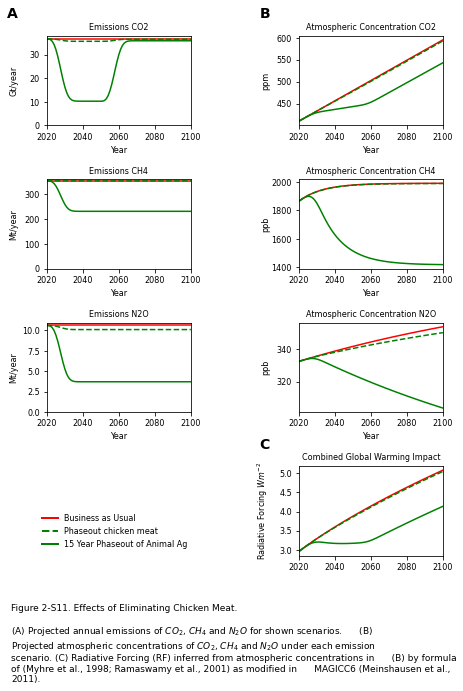

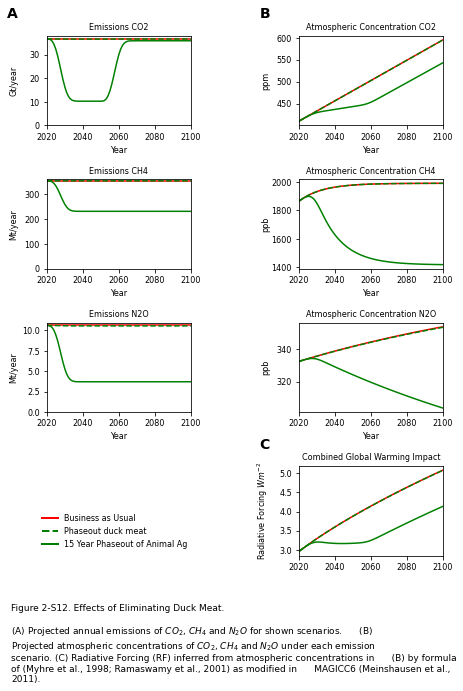

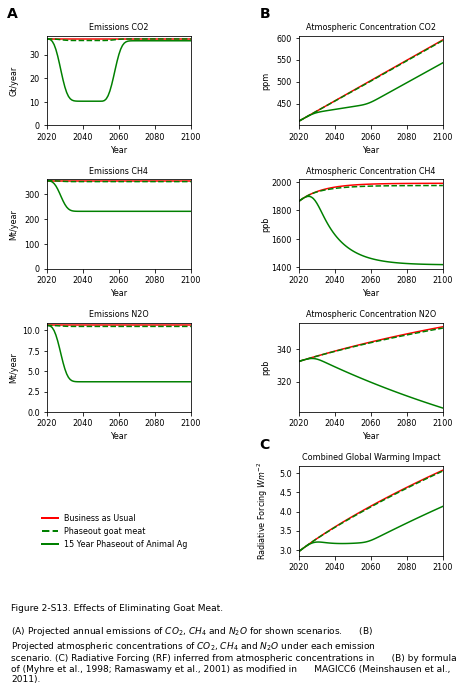

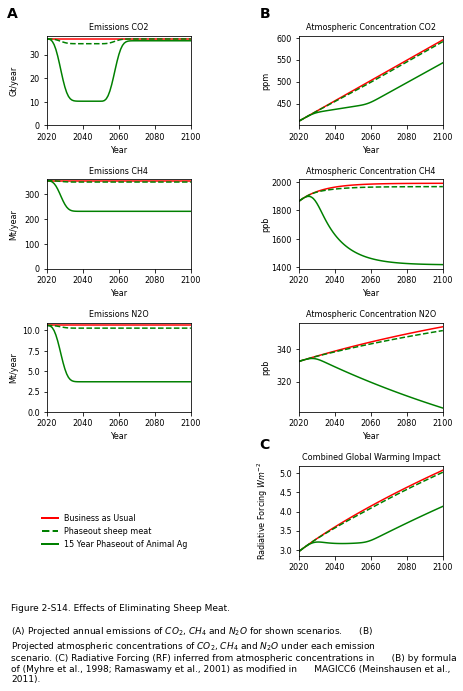

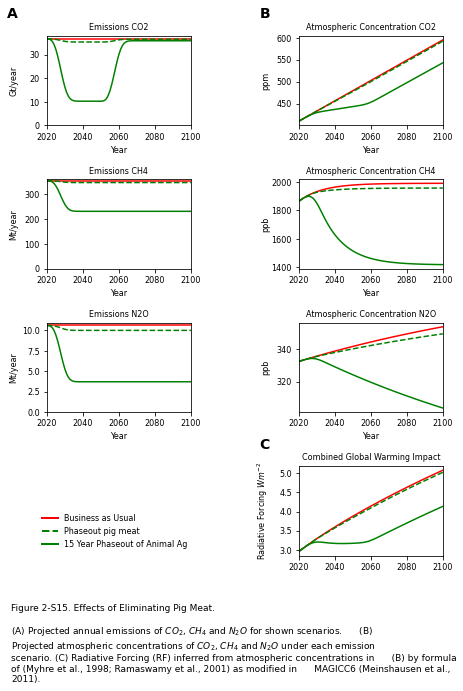

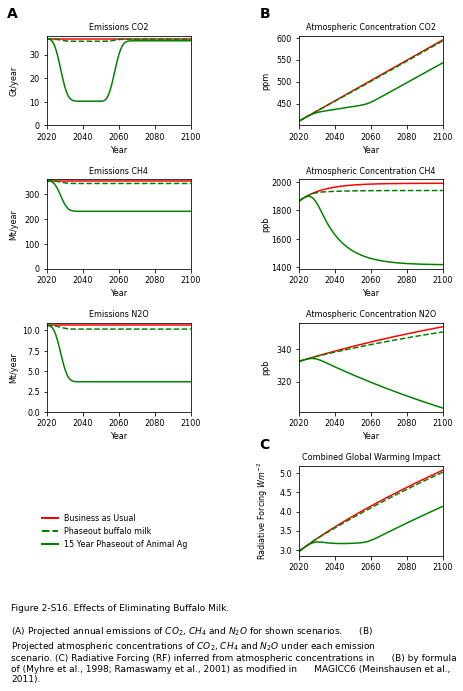

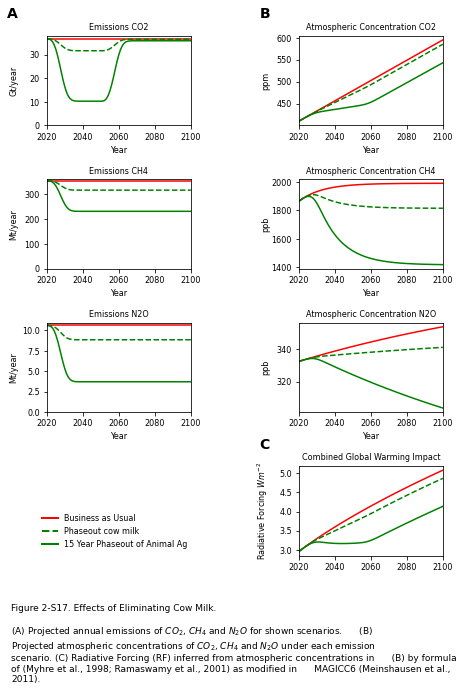

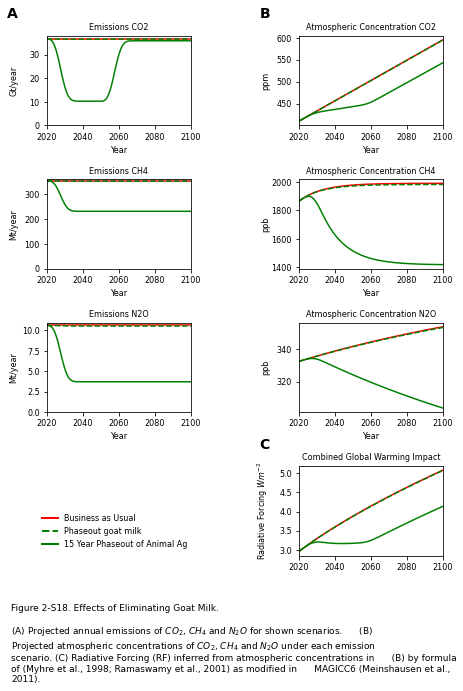

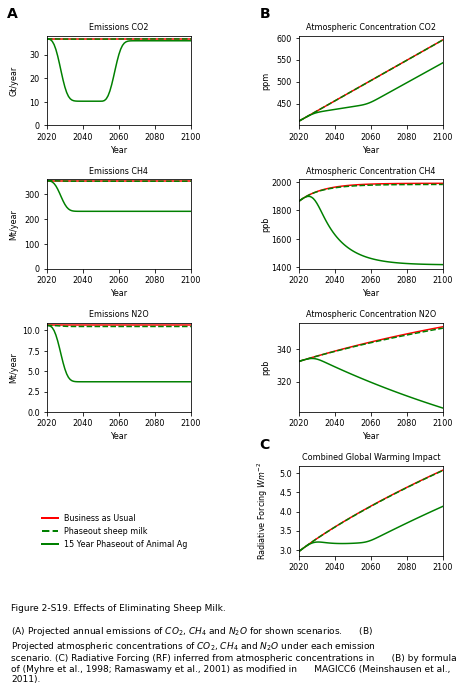

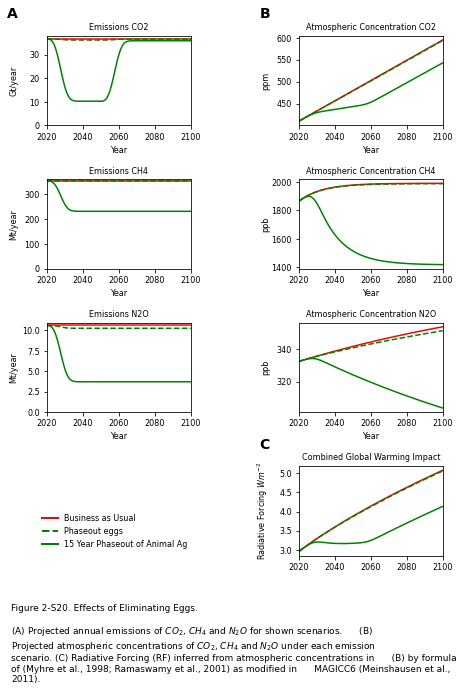

In [127]:
plot_names = {
    'Phaseout' : '15 Year Phaseout of Animal Ag',
    'Phaseout30' : '30 Year Phaseout of Animal Ag',
    'Elimination' : 'Immediate Elimination of Animal Ag',
    'Phaseout|Slow Recovery' : '15 Year Phaseout w/50 Year Biomass Recovery'
    
}


plot_scenarios = [
    ['Phaseout','Elimination','Phaseout compared to Elimination'],
    ['Phaseout','Phaseout30','Effects of Slower Phaseout'],
    ['Phaseout','Phaseout|Slow Recovery','Effects of Slower Biomass Recovery'],
]

for group in groups:
    scid = 'Phaseout|%s' % group
    plot_names[scid] = "Phaseout %s" % group.replace("_"," ")
    plot_scenarios.append(['Phaseout', scid,'Effects of Eliminating %s' % group.replace("_"," ").title()],)

fignum = 2

for i, plot_scenario in enumerate(plot_scenarios):
    supnum = (i+1)
    plotname = "Figure%d-S%d" % (fignum,supnum)
    plotlabel = r"Figure %d-S%d. %s." % (fignum,supnum,plot_scenario[2])
    plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for shown scenarios. 
    (B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission 
    scenario. (C) Radiative Forcing (RF) inferred from atmospheric concentrations in 
    (B) by formula of (Myhre et al., 1998; Ramaswamy et al., 2001) as modified in 
    MAGICC6 (Meinshausen et al., 2011).'''

    plotcaption = plotcaption.replace("CO2",r"$CO_2$")
    plotcaption = plotcaption.replace("CH4",r"$CH_4$")
    plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

    scen = plot_scenario[0]
    scenlabel = plot_names[plot_scenario[0]]
    
    if plot_scenario[1] != "":    
        scen2 = plot_scenario[1]
        scen2label = plot_names[plot_scenario[1]]
        EmLeRF_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)
    else:
        EmLeRF_plot(plotname,plotlabel,plotcaption,scen,scenlabel)




    

## Figure 4-S1

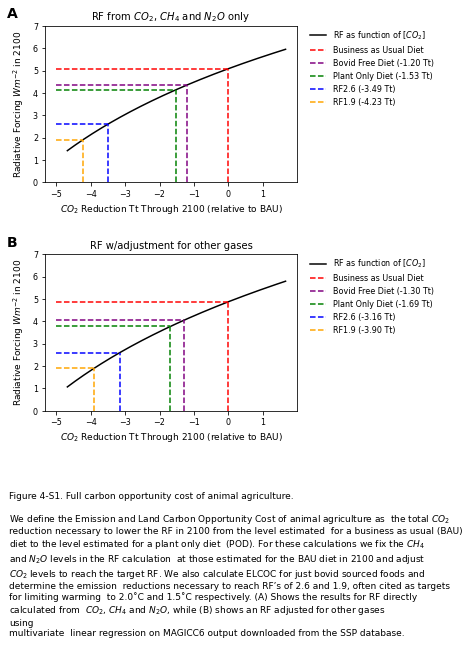

In [128]:
proj_end = scenarios.loc[2100]

fignum = 4
supnum = 1
pdffile = "Figures_Supplements/Figure%d-S%d.pdf" % (fignum,supnum)

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 1.5

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,500)

    CB = proj_end['Concentration|CO2|BAU']
    MB = proj_end['Concentration|CH4|BAU']
    NB = proj_end['Concentration|N2O|BAU']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    (x_C,x_M,x_N,x_R) = RF_MAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RF|BAU']))]
    ax.plot([px[0],xn],[proj_end['RF|BAU'],proj_end['RF|BAU']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RF|BAU']],c='red',linestyle='dashed')
    
    rft = proj_end['RF|Phaseout|bovids']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RF|Phaseout']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)

    ax.text(-.15,1.05,"A",transform=ax.transAxes,fontsize=14,fontweight='bold')
    title = r"RF from $CO_2$, $CH_4$ and $N_{2}O$ only"
    ax.set_title(title)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)

    
    panely = figh - margin_top - panelh - 1.0 - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,1000)

    CB = proj_end['Concentration|CO2|BAU']
    MB = proj_end['Concentration|CH4|BAU']
    NB = proj_end['Concentration|N2O|BAU']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    x_R = RF_cMAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RFC|BAU']))]
    ax.plot([px[0],xn],[proj_end['RFC|BAU'],proj_end['RFC|BAU']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RFC|BAU']],c='red',linestyle='dashed')
    
    rft = proj_end['RFC|Phaseout|bovids']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RFC|Phaseout']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)
    
    ax.text(-.15,1.05,"B",transform=ax.transAxes,fontsize=14,fontweight='bold')
    ax.set_title("RF w/adjustment for other gases")
    
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    
    flh = r"Figure %d-S%d. Full carbon opportunity cost of animal agriculture." % (fignum,supnum)
    
    flt = r'''We define the Emission and Land Carbon Opportunity Cost of animal agriculture as 
the total CO2 reduction necessary to lower the RF in 2100 from the level estimated 
for a business as usual (BAU) diet to the level estimated for a plant only diet 
(POD). For these calculations we fix the CH4 and N2O levels in the RF calculation 
at those estimated for the BAU diet in 2100 and adjust CO2 levels to reach the target RF.
We also calculate ELCOC for just bovid sourced foods and determine the emission 
reductions necessary to reach RF’s of 2.6 and 1.9, often cited as targets for limiting warming 
to 2.0˚C and 1.5˚C respectively. (A) Shows the results for RF directly calculated from 
CO2, CH4 and N2O, while (B) shows an RF adjusted for other gases using multivariate 
linear regression on MAGICC6 output downloaded from the SSP database.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

## Figure 5 Supplement - Details of Calibration for ACO2eq

In [129]:
def EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures_Supplements/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 1
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - 1 - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2,3]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }

        label_pos = -0.2
        
        r = scenarios.loc[2020:2100]
        rc = calib_scenarios.loc[2020:2100]
        
        for ai,gas in enumerate(gases):
            l1 = ax[ai][0].plot(r['Emissions|%s|BAU' % gas],c='red')
            l2 = ax[ai][0].plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
            l3 = ""
            if scen2 != "":
                l3 = ax[ai][0].plot(rc['Emissions|%s|%s' % (gas,scen2)],c='blue',linestyle='dashed')
            ax[ai][1].plot(r['Concentration|%s|BAU' % gas],c='red')
            ax[ai][1].plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
            if scen2 != "":
                ax[ai][1].plot(rc['Concentration|%s|%s' % (gas,scen2)],c='blue', linestyle='dashed')

            ax[ai][0].set_title("Emissions " + gas, fontsize=8)
            ax[ai][1].set_title("Atmospheric Concentration " + gas, fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        ax[3][1].plot(-r['CRFD|BAU'] * (5.1E+14/1E+15),c='red')
        ax[3][1].plot(-r['CRFD|%s' %scen] * (5.1E+14/1E+15),c='green')
        if scen2 != "":
            ax[3][1].plot(-rc['CRFD|%s' %scen2] * (5.1E+14/1E+15),c='blue',linestyle='dashed')
        ax[3][1].set_title("Reduced Atmospheric Heating", fontsize=8)
        ax[3][1].yaxis.set_label_coords(label_pos,0.5)

        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[3][1].text(label_pos,1.2,"C",transform=ax[3][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,4):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)

        for i in range(0,4):
            for j in range(0,2):
                ax[i][j].set_xlim(2020,2100)

        ax[3][0].set_visible(False)
        ax[3][1].set_ylabel("Cumulative RF Reduction\n(Petawatt-years)",fontsize=8)                


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2),
                Line2D([0],[0],color='blue', lw=2, linestyle='dashed'),
            ]
    
            legend_labels = [
                'Business as Usual',
                scenlabel,
                scen2label,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(-.75,.5), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
        #plt.savefig(pdffile.replace('pdf','png'),dpi=300)
    

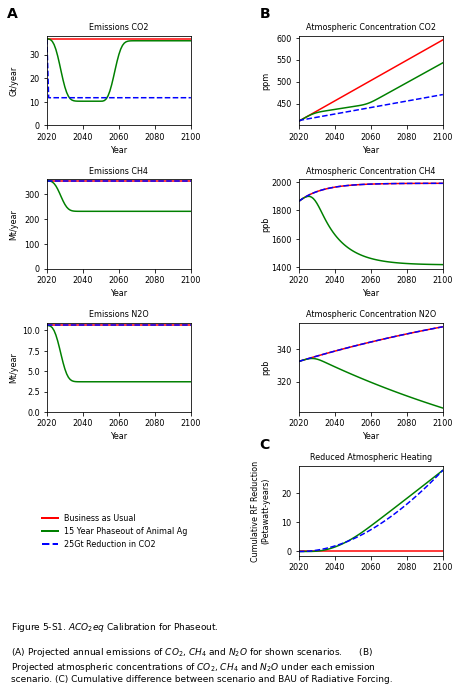

In [130]:
plot_names = {
    'Phaseout' : '15 Year Phaseout of Animal Ag',
    'Phaseout30' : '30 Year Phaseout of Animal Ag',
    'Elimination' : 'Immediate Elimination of Animal Ag',
    'Phaseout|cattle_meat' : '15 Year Phaseout of Beef',
    'Phaseout|bovids' : '15 Year Phaseout of Bovids',
    'Phaseout|ruminants' : '15 Year Phaseout of Ruminants',
    'Phaseout|Slow Recovery' : '15 Year Phaseout w/50 Year Biomass Recovery',
    'BAU_m25GT' : '25Gt Reduction in CO2'
    
}


plot_scenarios = [
    ['Phaseout','BAU_m25GT',r"$ACO_{2}eq$ Calibration for Phaseout"],
]


fignum = 5

for i, plot_scenario in enumerate(plot_scenarios):
    supnum = i+1
    plotname = "Figure%d-S%d" % (fignum,supnum)
    plotlabel = r"Figure %d-S%d. %s." % (fignum,supnum,plot_scenario[2])
    plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for shown scenarios. 
    (B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission 
    scenario. (C) Cumulative difference between scenario and BAU of Radiative Forcing.'''

    plotcaption = plotcaption.replace("CO2",r"$CO_2$")
    plotcaption = plotcaption.replace("CH4",r"$CH_4$")
    plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

    scen = plot_scenario[0]
    scenlabel = plot_names[plot_scenario[0]]
    
    if plot_scenario[1] != "":    
        scen2 = plot_scenario[1]
        scen2label = plot_names[plot_scenario[1]]
        EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)
    else:
        EmLeCRFCalib_plot(plotname,plotlabel,plotcaption,scen,scenlabel)




    

# Single Panel Figures for Web

<ipython-input-131-16c7751c35a1>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_species,fontsize=12)


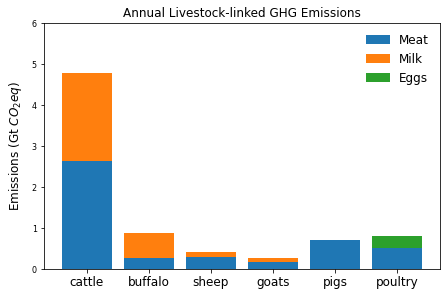

In [131]:
fc = 1

pngfile = "Figures_SinglePanel/Livestock_Emissions.png"

figw = 8.0
figh = 4.5

fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

panelw = 5.5
panelh = panelw/1.61

label_pos = -.05

margin_top = 1.5

panelx = (figw-panelw)/2
panely = (figh - panelh)/2

ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])

df = livestock_data.groupby('Category').sum()
df['Emissions'] = df['Emissions|CO2|Livestock'] + 34/1000 * df['Emissions|CH4|Livestock'] + 298/1000 * df['Emissions|N2O|Livestock']

plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
plot_meat = np.array([
    df.loc['cattle_meat'].Emissions,
    df.loc['buffalo_meat'].Emissions,
    df.loc['sheep_meat'].Emissions,
    df.loc['goat_meat'].Emissions,
    df.loc['pig_meat'].Emissions,
    df.loc['chicken_meat'].Emissions + df.loc['duck_meat'].Emissions,
    ])

plot_milk = np.array([
    df.loc['cow_milk'].Emissions,
    df.loc['buffalo_milk'].Emissions,
    df.loc['sheep_milk'].Emissions,
    df.loc['goat_milk'].Emissions,
    0,
    0,
])

plot_eggs = np.array([
    0,
    0,
    0,
    0,
    0,
    df.loc['eggs'].Emissions,
])

p1 = ax.bar(plot_species,plot_meat)
p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
ax.set_xticklabels(plot_species,fontsize=12)
ax.set_ylabel(r'Emissions (Gt $CO_{2}eq$)', fontsize=12)
ax.set_ylim(0,6)
ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False, fontsize=12)
ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)

ax.set_title("Annual Livestock-linked GHG Emissions",fontsize=12)


plt.savefig(pngfile,dpi=300)

<ipython-input-132-fa697fa7d061>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_species,fontsize=12)


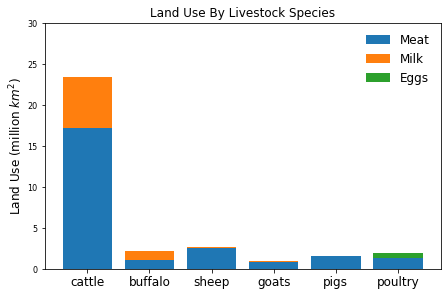

In [132]:
fc = 1

pngfile = "Figures_SinglePanel/Livestock_LandUse.png"

figw = 8.0
figh = 4.5

fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

panelw = 5.5
panelh = panelw/1.61

label_pos = -.05

margin_top = 1.5

panelx = (figw-panelw)/2
panely = (figh - panelh)/2

ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])

df = livestock_data.groupby('Category').sum()

plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
plot_meat = np.array([
    df.loc['cattle_meat']['Land Use'],
    df.loc['buffalo_meat']['Land Use'],
    df.loc['sheep_meat']['Land Use'],
    df.loc['goat_meat']['Land Use'],
    df.loc['pig_meat']['Land Use'],
    df.loc['chicken_meat']['Land Use'] + df.loc['duck_meat']['Land Use'], 
])

plot_milk = np.array([
    df.loc['cow_milk']['Land Use'],
    df.loc['buffalo_milk']['Land Use'],
    df.loc['sheep_milk']['Land Use'],
    df.loc['goat_milk']['Land Use'],
    0,
    0,
])

plot_eggs = np.array([
    0,
    0,
    0,
    0,
    0,
    df.loc['eggs']['Land Use'],
])

p1 = ax.bar(plot_species,plot_meat)
p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
ax.set_ylabel(r'Land Use (million $km^2$)',fontsize=12)
ax.set_ylim(0,30)
ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False,fontsize=12)
ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)

ax.set_xticklabels(plot_species,fontsize=12)
ax.set_title("Land Use By Livestock Species",fontsize=12)

plt.savefig(pngfile,dpi=300)

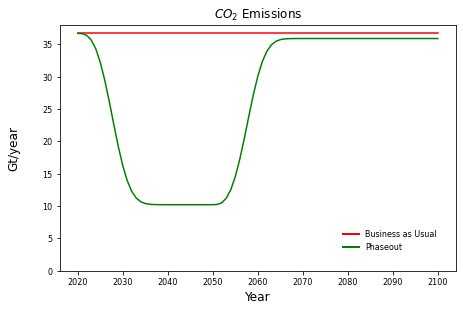

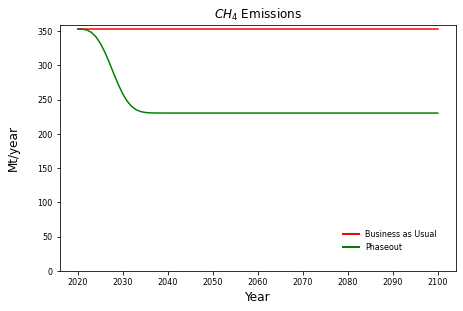

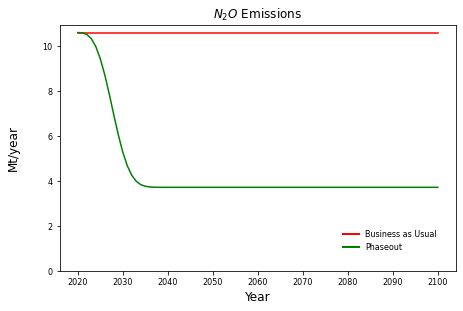

In [133]:
units = {
    'CO2' : "Gt/year",
    'CH4' : "Mt/year",
    'N2O' : "Mt/year"
}

pp_units = {
    'CO2' : "ppm",
    'CH4' : "ppb",
    'N2O' : "ppb"
}


factor = {
    'CO2' : 1,
    'CH4' : 1,
    'N2O' : 1
}

gas_label = {
    'CO2' : r"$CO_2$",
    'CH4' : r"$CH_4$",
    'N2O' : r"$N_{2}O$"
}

fc = 1

for gas in gases:
    
    pngfile = "Figures_SinglePanel/Emissions_%s.png" % gas

    figw = 8.0
    figh = 4.5

    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 5.5
    panelh = panelw/1.61

    label_pos = -.10

    margin_top = 1.5

    panelx = (figw-panelw)/2
    panely = (figh - panelh)/2

    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    r = scenarios.loc[2020:2100]
        
    scen = "Phaseout"
    l1 = ax.plot(r['Emissions|%s|BAU' % gas],c='red')
    l2 = ax.plot(r['Emissions|%s|%s' % (gas,scen)],c='green')
    
    ax.set_ylim(0,)
    
    title = gas_label[gas] + " Emissions"
    ax.set_title(title , fontsize=12)

    ax.set_ylabel(units[gas],fontsize=12)
    ax.set_ylim(0,)
    ax.yaxis.set_label_coords(label_pos,0.5)
    ax.set_xlabel("Year",fontsize=12)

    legend_lines = [
    Line2D([0],[0],color='red', lw=2),
    Line2D([0],[0],color='green', lw=2),
    ]

    legend_labels = [
        'Business as Usual',
        'Phaseout',
    ]

    plt.legend(legend_lines,legend_labels,loc = "lower right", borderaxespad=2, frameon=False)
    
    plt.savefig(pngfile,dpi=300)

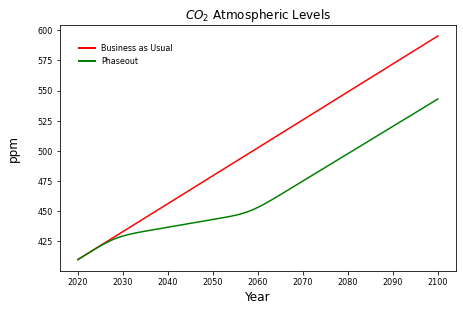

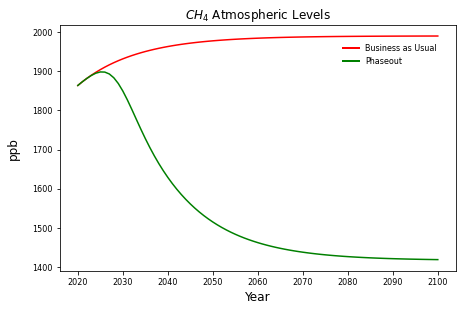

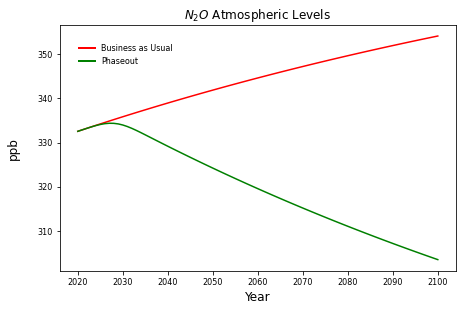

In [134]:
units = {
    'CO2' : "Gt/year",
    'CH4' : "Mt/year",
    'N2O' : "Mt/year"
}

pp_units = {
    'CO2' : "ppm",
    'CH4' : "ppb",
    'N2O' : "ppb"
}


factor = {
    'CO2' : 1,
    'CH4' : 1,
    'N2O' : 1
}

gas_label = {
    'CO2' : r"$CO_2$",
    'CH4' : r"$CH_4$",
    'N2O' : r"$N_{2}O$"
}

fc = 1

for gas in gases:
    
    pngfile = "Figures_SinglePanel/Concentration_%s.png" % gas

    figw = 8.0
    figh = 4.5

    fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

    panelw = 5.5
    panelh = panelw/1.61

    label_pos = -.10

    margin_top = 1.5

    panelx = (figw-panelw)/2
    panely = (figh - panelh)/2

    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    r = scenarios.loc[2020:2100]
        
    scen = "Phaseout"
    l1 = ax.plot(r['Concentration|%s|BAU' % gas],c='red')
    l2 = ax.plot(r['Concentration|%s|%s' % (gas,scen)],c='green')
    
    title = gas_label[gas] + " Atmospheric Levels"
    ax.set_title(title , fontsize=12)

    ax.set_ylabel(pp_units[gas],fontsize=12)
    ax.yaxis.set_label_coords(label_pos,0.5)
    ax.set_xlabel("Year",fontsize=12)

    legend_lines = [
    Line2D([0],[0],color='red', lw=2),
    Line2D([0],[0],color='green', lw=2),
    ]

    legend_labels = [
        'Business as Usual',
        'Phaseout',
    ]

    plt.legend(legend_lines,legend_labels,borderaxespad=2, frameon=False)
    
    plt.savefig(pngfile,dpi=300)

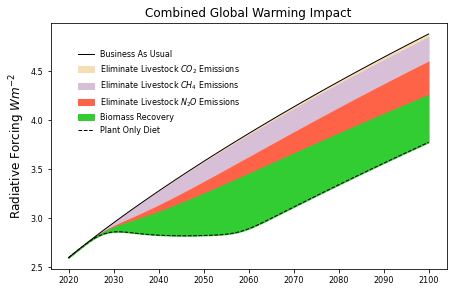

In [135]:


fc = 1

pngfile = "Figures_SinglePanel/RF.png" 

figw = 8.0
figh = 4.5

fig = plt.figure(figsize = (figw,figh),facecolor=(fc,fc,fc))

panelw = 5.5
panelh = panelw/1.61

label_pos = -.10

margin_top = 1.5

panelx = (figw-panelw)/2
panely = (figh - panelh)/2

ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])

df = scenarios.loc[2020:2100]

l1  = ax.plot(df.index,df['RFC|BAU'],color='black',label='Business as Usual',linewidth=1)
fb1 = ax.fill_between(df.index,df['RFC|BAU'],df['RFC|Phaseout_Breakdown_CO2'],label=r'Eliminate Livestock $CO_2$ Emissions',color='wheat')
fb2 = ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2'],df['RFC|Phaseout_Breakdown_CO2_CH4'],label=r'Eliminate Livestock $CH_4$ Emissions',color='thistle')
fb3 = ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4'],df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],label=r'Eliminate Livestock $N_{2}O$ Emissions',color='tomato')
fb4 = ax.fill_between(df.index,df['RFC|Phaseout_Breakdown_CO2_CH4_N2O'],df['RFC|Phaseout'],label='Biomass Recovery',color='limegreen')
l2  = ax.plot(df.index,df['RFC|Phaseout'],color='black',linestyle='dashed',label='Plant Only Diet',linewidth=1)
#df  = calib_scenarios.loc[2020:2100]
#ax.plot(df['RFC|BAU_m28GT'],c='gray',linestyle='dashed',label=r'28Gt/year $CO_2$ reduction from BAU')
ax.set_title("Combined Global Warming Impact", fontsize=12)

ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=12)       

ax.legend([l1[0],fb1,fb2,fb3,fb4,l2[0]],['Business As Usual',r'Eliminate Livestock $CO_2$ Emissions',r'Eliminate Livestock $CH_4$ Emissions',r'Eliminate Livestock $N_{2}O$ Emissions',
                                  'Biomass Recovery','Plant Only Diet'],loc="upper left", borderaxespad=3, frameon=False)


plt.savefig(pngfile,dpi=300)